<a href="https://colab.research.google.com/github/osmarbraz/exemplos_BERT/blob/main/ExemplosWordEmbeddingContextualBERT_pt_br.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exemplo de Desambiguação(pt-br) de palavras usando BERT Transformers by HuggingFace

# **A execução pode ser feita através do menu Ambiente de Execução opção Executar tudo.**

Exemplos de **Desambiguação de palavras(pt-br)** usando **BERT** em sentenças. No final do notebook estão os exemplos com as palavras:

*   banco
*   manga
*   cabeça
*   pilha

**Link biblioteca Huggingface:**
https://github.com/huggingface/transformers


**Artigo original BERT Jacob Devlin:**
https://arxiv.org/pdf/1506.06724.pdf

# 0 - Preparação do ambiente
Preparação do ambiente para execução do exemplo.

## Tratamento de logs

Método para tratamento dos logs.

In [1]:
# Biblioteca de logging
import logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)

## Identificando o ambiente Colab

Cria uma variável para identificar que o notebook está sendo executado no Google Colaboratory.

In [2]:
# Se estiver executando no Google Colaboratory
import sys

# Retorna true ou false se estiver no Google Colaboratory
IN_COLAB = "google.colab" in sys.modules

# 1 - Instalação BERT da Hugging Face

Instala a interface pytorch para o BERT by Hugging Face. 

In [3]:
# Instala a última versão da biblioteca
#!pip install transformers

# Instala uma versão específica da biblioteca
!pip install -U transformers==4.5.1

# 2 - Download do arquivo do PyTorch Checkpoint

Lista de modelos da comunidade:
* https://huggingface.co/models

Português(https://github.com/neuralmind-ai/portuguese-bert):  
* **"neuralmind/bert-base-portuguese-cased"**
* **"neuralmind/bert-large-portuguese-cased"**

In [4]:
# Importando as bibliotecas
import os

# Variável para setar o arquivo
URL_MODELO = None

# Comente uma das urls para carregar modelos de tamanhos diferentes(base/large)
# URL_MODELO do arquivo do modelo tensorflow
# arquivo menor(base) 1.1 Gbytes
#URL_MODELO = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-base-portuguese-cased/bert-base-portuguese-cased_pytorch_checkpoint.zip"

# arquivo grande(large) 3.5 Gbytes
#URL_MODELO = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-large-portuguese-cased/bert-large-portuguese-cased_pytorch_checkpoint.zip"

# Se a variável foi setada
if URL_MODELO:

    # Diretório descompactação
    DIRETORIO_MODELO = "/content/modelo"

    # Recupera o nome do arquivo do modelo da URL_MODELO
    arquivo = URL_MODELO.split("/")[-1]

    # Nome do arquivo do vocabulário
    arquivo_vocab = "vocab.txt"

    # Caminho do arquivo na URL_MODELO
    caminho = URL_MODELO[0:len(URL_MODELO)-len(arquivo)]

    # Verifica se a pasta de descompactação existe na pasta corrente
    if os.path.exists(DIRETORIO_MODELO):
      print("Apagando diretório existente do modelo!")
      # Apaga a pasta e os arquivos existentes
      !rm -rf $DIRETORIO_MODELO    

    # Baixa o arquivo do modelo
    !wget $URL_MODELO
    
    # Descompacta o arquivo na pasta de descompactação
    !unzip -o $arquivo -d $DIRETORIO_MODELO

    # Baixa o arquivo do vocabulário
    # O vocabulário não está no arquivo compactado acima, mesma url mas arquivo diferente
    URL_MODELO_VOCAB = caminho + arquivo_vocab
    !wget $URL_MODELO_VOCAB
    
    # Coloca o arquivo do vocabulário no diretório de descompactação
    !mv $arquivo_vocab $DIRETORIO_MODELO
            
    # Move o arquivo para pasta de descompactação
    !mv $arquivo $DIRETORIO_MODELO
       
    print("Pasta do " + DIRETORIO_MODELO + " pronta!")
    
    # Lista a pasta corrente
    !ls -la $DIRETORIO_MODELO
else:
    DIRETORIO_MODELO = None
    print("Variável URL_MODELO não setada!")

Variável URL_MODELO não setada!


# 3 - Carregando o Tokenizador BERT

O tokenizador utiliza WordPiece, veja em [artigo original](https://arxiv.org/pdf/1609.08144.pdf).

Carregando o tokenizador da pasta "/content/modelo/" do diretório padrão se variável `URL_MODELO` setada.

**Caso contrário carrega da comunidade**

Por default(`do_lower_case=True`) todas as letras são colocadas para minúsculas. Para ignorar a conversão para minúsculo use o parâmetro `do_lower_case=False`. Esta opção também considera as letras acentuadas(ãçéí...), que são necessárias a língua portuguesa.

O parâmetro `do_lower_case` interfere na quantidade tokens a ser gerado apartir de um documento. Quando igual a `False` reduz a quantidade de tokens gerados.

In [5]:
# Importando as bibliotecas do tokenizador
from transformers import BertTokenizer

# Se a variável URL_MODELO foi setada
if URL_MODELO:
    # Carregando o Tokenizador
    print("Carrgando o tokenizador BERT do diretório " + DIRETORIO_MODELO + "...")

    tokenizer = BertTokenizer.from_pretrained(DIRETORIO_MODELO, 
                                              do_lower_case=False)    
else:
    # Carregando o Tokenizador da comunidade
    print("Carregando o tokenizador da comunidade...")
    
    #tokenizer = BertTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased", do_lower_case=False)
    tokenizer = BertTokenizer.from_pretrained("neuralmind/bert-large-portuguese-cased", do_lower_case=False)

Carregando o tokenizador da comunidade...


# 4 - Carregando o Modelo BERT(BertModel)

Se a variável `URL_MODELO` estiver setada carrega o modelo do diretório `content/modelo`.

Caso contrário carrega da comunidade.

Carregando o modelo da pasta "/content/modelo/" do diretório padrão.

A implementação do huggingface pytorch inclui um conjunto de interfaces projetadas para uma variedade de tarefas de PNL. Embora essas interfaces sejam todas construídas sobre um modelo treinado de BERT, cada uma possui diferentes camadas superiores e tipos de saída projetados para acomodar suas tarefas específicas de PNL.

A documentação para estas pode ser encontrada em [aqui](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html).

Por default o modelo está em modo avaliação ou seja `model.eval()`.

-----------------------

Durante a avaliação do modelo, este retorna um número de diferentes objetos com base em como é configurado na chamada do método `from_pretrained`. 

Quando definimos `output_hidden_states = True` na chamada do método `from_pretrained`, retorno do modelo possui no terceiro item os estados ocultos(**hidden_states**) de todas as camadas.  Veja a documentação para mais detalhes: https://huggingface.co/transformers/model_doc/bert.html#bertmodel

Quando **`output_hidden_states = True`** model retorna:
- outputs[0] = last_hidden_state;
- outputs[1] = pooler_output; 
- outputs[2] = hidden_states.

Quando **`output_hidden_states = False`** ou não especificado model retorna:
- outputs[0] = last_hidden_state;
- outputs[1] = pooler_output.


**ATENÇÃO**: O parâmetro ´**output_hidden_states = True**´ habilita gerar as camadas ocultas do modelo. Caso contrário somente a última camada é mantida. Este parâmetro otimiza a memória mas não os resultados.


In [6]:
# Importando as bibliotecas do Modelo
from transformers import BertModel

# Se a variável URL_MODELO1 foi setada
if URL_MODELO:
    # Carregando o Tokenizador
    print("Carregando o modelo BERT do diretório " + DIRETORIO_MODELO + "...")

    model = BertModel.from_pretrained(DIRETORIO_MODELO, 
                                      output_hidden_states = True)    
else:
    # Carregando o Tokenizador da comunidade
    print("Carregando o modelo BERT da comunidade ...")

    model = BertModel.from_pretrained("neuralmind/bert-large-portuguese-cased", 
                                       output_hidden_states = True)

Carregando o modelo BERT da comunidade ...


# 5 - Funções auxiliares

#### getEmbeddingsCamadas

Funções que recuperam os embeddings das camadas:
- Primeira camada;
- Penúltima camada;
- Ùltima camada;
- Soma das 4 últimas camadas;
- Concatenação das 4 últimas camadas;
- Soma de todas as camadas.

In [7]:
def getEmbeddingPrimeiraCamada(output):
  # outputs[0] = last_hidden_state, outputs[1] = pooler_output, outputs[2] = hidden_states
  # hidden_states é uma lista python, e cada elemento um tensor pytorch no formado <lote> x <qtde_tokens> x <768 ou 1024>.
      
  # Retorna todas a primeira(-1) camada
  # Entrada: List das camadas(13 ou 25) (<1(lote)> x <qtde_tokens> <768 ou 1024>)  
  resultado = output[2][0]
  # Saída: (<1(lote)> x <qtde_tokens> <768 ou 1024>)  
  
  return resultado

def getEmbeddingPenultimaCamada(output):
  # outputs[0] = last_hidden_state, outputs[1] = pooler_output, outputs[2] = hidden_states
  # hidden_states é uma lista python, e cada elemento um tensor pytorch no formado <lote> x <qtde_tokens> x <768 ou 1024>.
      
  # Retorna todas a primeira(-1) camada
  # Entrada: List das camadas(13 ou 25) (<1(lote)> x <qtde_tokens> <768 ou 1024>)  
  resultado = output[2][-2]
  # Saída: (<1(lote)> x <qtde_tokens> <768 ou 1024>)  
  
  return resultado

def getEmbeddingUltimaCamada(output):
  # outputs[0] = last_hidden_state, outputs[1] = pooler_output, outputs[2] = hidden_states
  # hidden_states é uma lista python, e cada elemento um tensor pytorch no formado <lote> x <qtde_tokens> x <768 ou 1024>.
     
  # Retorna todas a primeira(-1) camada
  # Entrada: List das camadas(13 ou 25) (<1(lote)> x <qtde_tokens> <768 ou 1024>)  
  resultado = output[2][-1]
  # Saída: (<1(lote)> x <qtde_tokens> <768 ou 1024>)  
  
  return resultado    

def getEmbeddingSoma4UltimasCamadas(output):
  # outputs[0] = last_hidden_state, outputs[1] = pooler_output, outputs[2] = hidden_states
  # hidden_states é uma lista python, e cada elemento um tensor pytorch no formado <lote> x <qtde_tokens> x <768 ou 1024>.
      
  # Retorna todas a primeira(-1) camada
  # Entrada: List das camadas(13 ou 25) (<1(lote)> x <qtde_tokens> <768 ou 1024>)  
  embeddingCamadas = output[2][-4:]
  # Saída: List das camadas(4) (<1(lote)> x <qtde_tokens> <768 ou 1024>)  

  # Usa o método `stack` para criar uma nova dimensão no tensor 
  # com a concateção dos tensores dos embeddings.        
  #Entrada: List das camadas(4) (<1(lote)> x <qtde_tokens> <768 ou 1024>)  
  resultadoStack = torch.stack(embeddingCamadas, dim=0)
  # Saída: <4> x <1(lote)> x <qtde_tokens> x <768 ou 1024>
  
  # Realiza a soma dos embeddings de todos os tokens para as camadas
  # Entrada: <4> x <1(lote)> x <qtde_tokens> x <768 ou 1024>
  resultado = torch.sum(resultadoStack, dim=0)
  # Saida: <1(lote)> x <qtde_tokens> x <768 ou 1024>
  
  return resultado

def getEmbeddingConcat4UltimasCamadas(output):  
  # outputs[0] = last_hidden_state, outputs[1] = pooler_output, outputs[2] = hidden_states
  # hidden_states é uma lista python, e cada elemento um tensor pytorch no formado <lote> x <qtde_tokens> x <768 ou 1024>.
      
  # Cria uma lista com os tensores a serem concatenados
  # Entrada: List das camadas(13 ou 25) (<1(lote)> x <qtde_tokens> <768 ou 1024>)  
  # Lista com os tensores a serem concatenados
  listaConcat = []
  # Percorre os 4 últimos
  for i in [-1,-2,-3,-4]:
      # Concatena da lista
      listaConcat.append(output[2][i])
  # Saída: Entrada: List das camadas(4) (<1(lote)> x <qtde_tokens> <768 ou 1024>)  
  
  # Realiza a concatenação dos embeddings de todos as camadas
  # Saída: Entrada: List das camadas(4) (<1(lote)> x <qtde_tokens> <768 ou 1024>)  
  resultado = torch.cat(listaConcat, dim=-1)
  # Saída: Entrada: (<1(lote)> x <qtde_tokens> <3072 ou 4096>)  
    
  return resultado   

def getEmbeddingSomaTodasAsCamada(output):
  # outputs[0] = last_hidden_state, outputs[1] = pooler_output, outputs[2] = hidden_states
  # hidden_states é uma lista python, e cada elemento um tensor pytorch no formado <lote> x <qtde_tokens> x <768 ou 1024>.
   
  # Retorna todas as camadas descontando a primeira(0)
  # Entrada: List das camadas(13 ou 25) (<1(lote)> x <qtde_tokens> <768 ou 1024>)  
  embeddingCamadas = output[2][1:]
  # Saída: List das camadas(12 ou 24) (<1(lote)> x <qtde_tokens> <768 ou 1024>)  
  
  # Usa o método `stack` para criar uma nova dimensão no tensor 
  # com a concateção dos tensores dos embeddings.        
  #Entrada: List das camadas(12 ou 24) (<1(lote)> x <qtde_tokens> <768 ou 1024>)  
  resultadoStack = torch.stack(embeddingCamadas, dim=0)
  # Saída: <12 ou 24> x <1(lote)> x <qtde_tokens> x <768 ou 1024>
    
  # Realiza a soma dos embeddings de todos os tokens para as camadas
  # Entrada: <12 ou 24> x <1(lote)> x <qtde_tokens> x <768 ou 1024>
  resultado = torch.sum(resultadoStack, dim=0)
  # Saida: <1(lote)> x <qtde_tokens> x <768 ou 1024>
    
  return resultado

#### Imports

In [8]:
# Import das bibliotecas
import numpy as np
import torch

import matplotlib.pyplot as plt
%matplotlib inline

#### getEmbeddingsVisual

Função para gerar as coordenadas de plotagem a partir das sentenças de embeddings.

Existe uma função para os tipos de camadas utilizadas:
- Ùltima camada;
- Soma das 4 últimas camadas;
- Concatenação das 4 últimas camadas;
- Soma de todas as camadas.

In [9]:
def getEmbeddingsVisualUltimaCamada(documento, modelo, tokenizador):
    
    # Adiciona os tokens especiais
    documento_marcado = "[CLS] " + documento + " [SEP]"

    # Divide a sentença em tokens
    documento_tokenizado = tokenizador.tokenize(documento_marcado)

    # Mapeia as strings dos tokens em seus índices do vocabuário    
    tokens_indexados = tokenizador.convert_tokens_to_ids(documento_tokenizado)
    
    # Marca cada um dos tokens como pertencentes à sentença "1".
    mascara_atencao = [1] * len(documento_tokenizado)

    # Converte a entrada em tensores
    tokens_tensores = torch.as_tensor([tokens_indexados])
    mascara_atencao_tensores = torch.as_tensor([mascara_atencao])
    
    # Prediz os atributos dos estados ocultos para cada camada
    with torch.no_grad():        
        # Retorno de model quando ´output_hidden_states=True´ é setado:  
        #outputs[0] = last_hidden_state, outputs[1] = pooler_output, outputs[2] = hidden_states
        outputs = modelo(tokens_tensores, mascara_atencao_tensores)

    # Camada embedding    
    camada = getEmbeddingUltimaCamada(outputs)

    # Remove a dimensão 1, o lote "batches".
    token_embeddings = torch.squeeze(camada, dim=0)

    # Recupera os embeddings dos tokens como um vetor
    embeddings = token_embeddings.numpy()

    # Converte para um array
    W = np.array(embeddings)
    # Transforma em um array
    B = np.array([embeddings[0], embeddings[-1]])
    # Invertee B.T
    Bi = np.linalg.pinv(B.T)

    #Projeta a palavra no espaço
    Wp = np.matmul(Bi,W.T)

    return Wp, documento_tokenizado

In [10]:
def getEmbeddingsVisualSoma4UltimasCamadas(documento, modelo, tokenizador):
    
    # Adiciona os tokens especiais
    documento_marcado = "[CLS] " + documento + " [SEP]"

    # Divide a sentença em tokens
    documento_tokenizado = tokenizador.tokenize(documento_marcado)

    # Mapeia as strings dos tokens em seus índices do vocabuário    
    tokens_indexados = tokenizador.convert_tokens_to_ids(documento_tokenizado)
    
    # Marca cada um dos tokens como pertencentes à sentença "1".
    mascara_atencao = [1] * len(documento_tokenizado)

    # Converte a entrada em tensores
    tokens_tensores = torch.as_tensor([tokens_indexados])
    mascara_atencao_tensores = torch.as_tensor([mascara_atencao])
    
    # Prediz os atributos dos estados ocultos para cada camada
    with torch.no_grad():        
        # Retorno de model quando ´output_hidden_states=True´ é setado:  
        #outputs[0] = last_hidden_state, outputs[1] = pooler_output, outputs[2] = hidden_states
        outputs = modelo(tokens_tensores, mascara_atencao_tensores)

    # Camada embedding    
    camada = getEmbeddingSoma4UltimasCamadas(outputs)

    # Remove a dimensão 1, o lote "batches".
    token_embeddings = torch.squeeze(camada, dim=0)

    # Recupera os embeddings dos tokens como um vetor
    embeddings = token_embeddings.numpy()

    # Converte para um array
    W = np.array(embeddings)
    # Transforma em um array
    B = np.array([embeddings[0], embeddings[-1]])
    # Invertee B.T
    Bi = np.linalg.pinv(B.T)

    #Projeta a palavra no espaço
    Wp = np.matmul(Bi,W.T)

    return Wp, documento_tokenizado

In [11]:
def getEmbeddingsVisualConcat4UltimasCamadas(documento, modelo, tokenizador):
    
    # Adiciona os tokens especiais
    documento_marcado = "[CLS] " + documento + " [SEP]"

    # Divide a sentença em tokens
    documento_tokenizado = tokenizador.tokenize(documento_marcado)

    # Mapeia as strings dos tokens em seus índices do vocabuário    
    tokens_indexados = tokenizador.convert_tokens_to_ids(documento_tokenizado)
    
    # Marca cada um dos tokens como pertencentes à sentença "1".
    mascara_atencao = [1] * len(documento_tokenizado)

    # Converte a entrada em tensores
    tokens_tensores = torch.as_tensor([tokens_indexados])
    mascara_atencao_tensores = torch.as_tensor([mascara_atencao])
    
    # Prediz os atributos dos estados ocultos para cada camada
    with torch.no_grad():        
        # Retorno de model quando ´output_hidden_states=True´ é setado:  
        #outputs[0] = last_hidden_state, outputs[1] = pooler_output, outputs[2] = hidden_states
        outputs = modelo(tokens_tensores, mascara_atencao_tensores)

    # Camada embedding    
    camada = getEmbeddingConcat4UltimasCamadas(outputs)

    # Remove a dimensão 1, o lote "batches".
    token_embeddings = torch.squeeze(camada, dim=0)

    # Recupera os embeddings dos tokens como um vetor
    embeddings = token_embeddings.numpy()

    # Converte para um array
    W = np.array(embeddings)
    # Transforma em um array
    B = np.array([embeddings[0], embeddings[-1]])
    # Invertee B.T
    Bi = np.linalg.pinv(B.T)

    #Projeta a palavra no espaço
    Wp = np.matmul(Bi,W.T)

    return Wp, documento_tokenizado

In [12]:
def getEmbeddingsVisualSomaTodasAsCamadas(documento, modelo, tokenizador):
    
    # Adiciona os tokens especiais
    documento_marcado = "[CLS] " + documento + " [SEP]"

    # Divide a sentença em tokens
    documento_tokenizado = tokenizador.tokenize(documento_marcado)

    # Mapeia as strings dos tokens em seus índices do vocabuário    
    tokens_indexados = tokenizador.convert_tokens_to_ids(documento_tokenizado)
    
    # Marca cada um dos tokens como pertencentes à sentença "1".
    mascara_atencao = [1] * len(documento_tokenizado)

    # Converte a entrada em tensores
    tokens_tensores = torch.as_tensor([tokens_indexados])
    mascara_atencao_tensores = torch.as_tensor([mascara_atencao])
    
    # Prediz os atributos dos estados ocultos para cada camada
    with torch.no_grad():        
        # Retorno de model quando ´output_hidden_states=True´ é setado:  
        #outputs[0] = last_hidden_state, outputs[1] = pooler_output, outputs[2] = hidden_states
        outputs = modelo(tokens_tensores, mascara_atencao_tensores)

    # Camada embedding    
    camada = getEmbeddingSomaTodasAsCamada(outputs)

    # Remove a dimensão 1, o lote "batches".
    token_embeddings = torch.squeeze(camada, dim=0)

    # Recupera os embeddings dos tokens como um vetor
    embeddings = token_embeddings.numpy()

    # Converte para um array
    W = np.array(embeddings)
    # Transforma em um array
    B = np.array([embeddings[0], embeddings[-1]])
    # Invertee B.T
    Bi = np.linalg.pinv(B.T)

    #Projeta a palavra no espaço
    Wp = np.matmul(Bi,W.T)

    return Wp, documento_tokenizado

#### getEmbeddings

Função para gerar os embeddings das sentenças.

Existe uma função para os tipos de camadas utilizadas:
- Ùltima camada;
- Soma das 4 últimas camadas;
- Concatenação das 4 últimas camadas;
- Soma de todas as camadas.

In [13]:
def getEmbeddingsUltimaCamada(documento, modelo, tokenizador):
    
    # Adiciona os tokens especiais
    documento_marcado = "[CLS] " + documento + " [SEP]"

    # Divide a sentença em tokens
    documento_tokenizado = tokenizador.tokenize(documento_marcado)

    # Mapeia as strings dos tokens em seus índices do vocabuário    
    tokens_indexados = tokenizador.convert_tokens_to_ids(documento_tokenizado)
    
    # Marca cada um dos tokens como pertencentes à sentença "1".
    mascara_atencao = [1] * len(documento_tokenizado)

    # Converte a entrada em tensores
    tokens_tensores = torch.as_tensor([tokens_indexados])
    mascara_atencao_tensores = torch.as_tensor([mascara_atencao])
    
    # Prediz os atributos dos estados ocultos para cada camada
    with torch.no_grad():        
        # Retorno de model quando ´output_hidden_states=True´ é setado:  
        #outputs[0] = last_hidden_state, outputs[1] = pooler_output, outputs[2] = hidden_states
        outputs = modelo(tokens_tensores, mascara_atencao_tensores)

    # Camada embedding    
    camada = getEmbeddingUltimaCamada(outputs)

    # Remove a dimensão 1, o lote "batches".
    token_embeddings = torch.squeeze(camada, dim=0)
 
    return token_embeddings, documento_tokenizado

In [14]:
def getEmbeddingsSoma4UltimasCamadas(documento, modelo, tokenizador):
    
    # Adiciona os tokens especiais
    documento_marcado = "[CLS] " + documento + " [SEP]"

    # Divide a sentença em tokens
    documento_tokenizado = tokenizador.tokenize(documento_marcado)

    # Mapeia as strings dos tokens em seus índices do vocabuário    
    tokens_indexados = tokenizador.convert_tokens_to_ids(documento_tokenizado)
    
    # Marca cada um dos tokens como pertencentes à sentença "1".
    mascara_atencao = [1] * len(documento_tokenizado)

    # Converte a entrada em tensores
    tokens_tensores = torch.as_tensor([tokens_indexados])
    mascara_atencao_tensores = torch.as_tensor([mascara_atencao])
    
    # Prediz os atributos dos estados ocultos para cada camada
    with torch.no_grad():        
        # Retorno de model quando ´output_hidden_states=True´ é setado:  
        #outputs[0] = last_hidden_state, outputs[1] = pooler_output, outputs[2] = hidden_states
        outputs = modelo(tokens_tensores, mascara_atencao_tensores)

    # Camada embedding    
    camada = getEmbeddingSoma4UltimasCamadas(outputs)

    # Remove a dimensão 1, o lote "batches".
    token_embeddings = torch.squeeze(camada, dim=0)
   
    return token_embeddings, documento_tokenizado

In [15]:
def getEmbeddingsConcat4UltimasCamadas(documento, modelo, tokenizador):
    
    # Adiciona os tokens especiais
    documento_marcado = "[CLS] " + documento + " [SEP]"

    # Divide a sentença em tokens
    documento_tokenizado = tokenizador.tokenize(documento_marcado)

    # Mapeia as strings dos tokens em seus índices do vocabuário    
    tokens_indexados = tokenizador.convert_tokens_to_ids(documento_tokenizado)
    
    # Marca cada um dos tokens como pertencentes à sentença "1".
    mascara_atencao = [1] * len(documento_tokenizado)

    # Converte a entrada em tensores
    tokens_tensores = torch.as_tensor([tokens_indexados])
    mascara_atencao_tensores = torch.as_tensor([mascara_atencao])
    
    # Prediz os atributos dos estados ocultos para cada camada
    with torch.no_grad():        
        # Retorno de model quando ´output_hidden_states=True´ é setado:  
        #outputs[0] = last_hidden_state, outputs[1] = pooler_output, outputs[2] = hidden_states
        outputs = modelo(tokens_tensores, mascara_atencao_tensores)

    # Camada embedding    
    camada = getEmbeddingConcat4UltimasCamadas(outputs)

    # Remove a dimensão 1, o lote "batches".
    token_embeddings = torch.squeeze(camada, dim=0)

    return token_embeddings, documento_tokenizado

In [16]:
def getEmbeddingsSomaTodasAsCamadas(documento, modelo, tokenizador):
    
    # Adiciona os tokens especiais
    documento_marcado = "[CLS] " + documento + " [SEP]"

    # Divide a sentença em tokens
    documento_tokenizado = tokenizador.tokenize(documento_marcado)

    # Mapeia as strings dos tokens em seus índices do vocabuário    
    tokens_indexados = tokenizador.convert_tokens_to_ids(documento_tokenizado)
    
    # Marca cada um dos tokens como pertencentes à sentença "1".
    mascara_atencao = [1] * len(documento_tokenizado)

    # Converte a entrada em tensores
    tokens_tensores = torch.as_tensor([tokens_indexados])
    mascara_atencao_tensores = torch.as_tensor([mascara_atencao])
    
    # Prediz os atributos dos estados ocultos para cada camada
    with torch.no_grad():        
        # Retorno de model quando ´output_hidden_states=True´ é setado:  
        #outputs[0] = last_hidden_state, outputs[1] = pooler_output, outputs[2] = hidden_states
        outputs = modelo(tokens_tensores, mascara_atencao_tensores)

    # Camada embedding    
    camada = getEmbeddingSomaTodasAsCamada(outputs)

    # Remove a dimensão 1, o lote "batches".
    token_embeddings = torch.squeeze(camada, dim=0)

    return token_embeddings, documento_tokenizado

# 6 - Exemplos palavra e as camadas do BERT

## 6.1 - Exemplo palavra "banco"

O exemplo com a palavra banco foi realizado utilizando a última camada, soma das 4 últimas, concatenação das 4 últimas camadas e a soma de todas as camadas.

### 6.1.1 Com a última camada

#### Inicialização

In [17]:
# Define um sentença de exemplo com diversos significados da palavra  "banco"
documento = "Depois de roubar o cofre do banco,"\
        " o ladrão de banco foi visto " \
        "sentado no banco da praça central."

# Adiciona os tokens especiais
documento_marcado = "[CLS] " + documento + " [SEP]"

# Divide a sentença em tokens
documento_tokenizado = tokenizer.tokenize(documento_marcado)

# Mapeia os tokens em seus índices do vocabulário
tokens_indexados = tokenizer.convert_tokens_to_ids(documento_tokenizado)

# Mostra os tokens com seus índices
i = 0
for tup in zip(documento_tokenizado, tokens_indexados):
    print("{:>3} {:<12} {:>6,}".format(i, tup[0], tup[1]))
    i= i + 1

  0 [CLS]           101
  1 Depois        1,603
  2 de              125
  3 roubar       16,150
  4 o               146
  5 co              144
  6 ##fre         1,198
  7 do              171
  8 banco         6,465
  9 ,               117
 10 o               146
 11 lad          13,503
 12 ##rão         1,759
 13 de              125
 14 banco         6,465
 15 foi             262
 16 visto         3,382
 17 sentado      21,541
 18 no              202
 19 banco         6,465
 20 da              180
 21 praça         6,357
 22 central       2,692
 23 .               119
 24 [SEP]           102


O BERT é treinado e espera pares de sentenças, usando 1s e 0s para distinguir entre as duas sentenças. Ou seja, para cada token em "documento_tokenizado", devemos especificar a qual sentença pertence: sentença 0 (uma série de 0s) ou sentença 1 (uma série de 1s). Para nossos propósitos, as entradas de sentença única requerem apenas uma série de 1s; portanto, criaremos um vetor de 1s para cada token em nossa sentença de entrada.

Se você deseja processar duas sentenças, atribua cada palavra na primeira sentença mais o token "[SEP]" a 0 e todos os tokens da segunda sentença a 1.

In [18]:
# Marca cada um dos tokens como pertencentes à sentença "1", pois só iremos analisar uma.
mascara_atencao = [1] * len(documento_tokenizado)

print (mascara_atencao)
print (len(mascara_atencao))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
25


Converte "tokens_indexados" e "semegmentos_ids" em  listas em tensores.

In [19]:
# Importa a bibliteca
import torch

# Converte as entradas de listas para tensores do torch
tokens_tensores = torch.as_tensor([tokens_indexados])
mascara_atencao_tensores = torch.as_tensor([mascara_atencao])

Gera os embeddings para a sentença e retorna a saída em  `outputs`.


In [20]:
# Prediz os atributos dos estados ocultos para cada camada
with torch.no_grad():    
  
    # Retorno de model quando output_hidden_states=True´ é setado:    
    #outputs[0] = last_hidden_state, outputs[1] = pooler_output, outputs[2] = hidden_states
    outputs = model(tokens_tensores, mascara_atencao_tensores)

#### Visualizando o intervalo de valores

Recupera a última camada.

In [21]:
# Recupera a última camada oculta da saída
last_hidden_states = getEmbeddingUltimaCamada(outputs)

print ("O vetor da última camada oculta tem o formato:", last_hidden_states.size())

O vetor da última camada oculta tem o formato: torch.Size([1, 25, 1024])


Plota de valores para o token.

('banco', 6465)


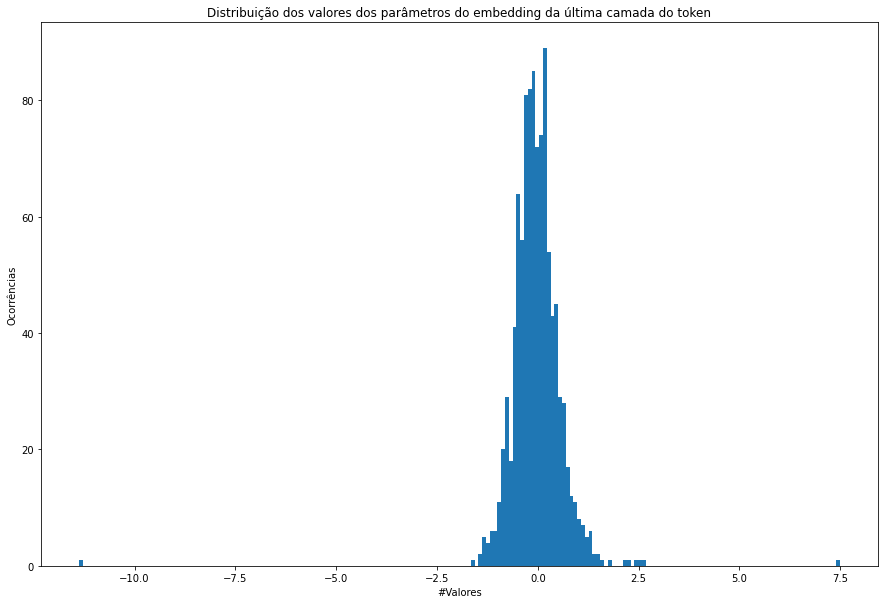

In [22]:
# Import da biblioteca gráfica
import matplotlib.pyplot as plt
%matplotlib inline

# Plota os tokens da sentença
token_i = 8
layer_i = 0

# Recupera o vetor de embeddings da camada para o token
vec = last_hidden_states[layer_i][token_i]

# Mostra a palavra do token_i
print((documento_tokenizado[token_i], tokens_indexados[token_i]))

# Aumenta o tamanho da plotagem do gráfico
plt.figure(figsize=(15,10))

# Título do gráfico
plt.title("Distribuição dos valores dos parâmetros do embedding da última camada do token")
# Documento do eixo x
plt.xlabel("#Valores")
# Documento do eixo y
plt.ylabel("Ocorrências")

# Cria o histograma com 200 classes
plt.hist(vec, bins=200)

# Mostra o gráfico
plt.show()

Vamos nos livrar da dimensão lotes "batches", pois não precisamos dela.

In [23]:
print ("O vetor da última camada oculta tem o formato:", last_hidden_states.size())

# Remove a dimensão 1, o lote "batches".
# O método ´squeeze´ remove a primeira dimensão(0) pois possui tamanho 1
token_embeddings = torch.squeeze(last_hidden_states, dim=0)

print ("O vetor de tokens de embedding da senteça tem o formato:", token_embeddings.size())

O vetor da última camada oculta tem o formato: torch.Size([1, 25, 1024])
O vetor de tokens de embedding da senteça tem o formato: torch.Size([25, 1024])


Confirmando vetores dependentes do documento


In [24]:
for i, token_str in enumerate(documento_tokenizado):
  print (i, token_str)

0 [CLS]
1 Depois
2 de
3 roubar
4 o
5 co
6 ##fre
7 do
8 banco
9 ,
10 o
11 lad
12 ##rão
13 de
14 banco
15 foi
16 visto
17 sentado
18 no
19 banco
20 da
21 praça
22 central
23 .
24 [SEP]


Exibe os embenddings das palavras

A banco aparece nos índices 8, 14 e 19.


In [25]:
# Índice das palavras a serem comparadas
palavra1 = 8
palavra2 = 14
palavra3 = 19

print("Os primeiros 5 valores de cada instância de \"banco\".")
print("")
print(documento_tokenizado[palavra1], str(token_embeddings[palavra1][:5]))
print(documento_tokenizado[palavra2], str(token_embeddings[palavra2][:5]))
print(documento_tokenizado[palavra3], str(token_embeddings[palavra3][:5]))

Os primeiros 5 valores de cada instância de "banco".

banco tensor([ 0.4261, -0.1251, -0.4406,  0.0736, -1.4059])
banco tensor([ 0.4835,  0.1447, -0.4306,  0.3436, -1.4682])
banco tensor([ 0.3631,  0.9212,  0.1919, -0.2493, -0.9418])


#### Comparando as palavras das sentenças
Podemos ver que os valores diferem, mas vamos calcular a semelhança de cosseno entre os vetores para fazer uma comparação mais precisa.

In [26]:
# Importando as bibliotecas
from scipy.spatial.distance import cosine

print("Período:", documento)
print("Palavra 1 =", palavra1, "=", documento_tokenizado[palavra1], "(instituição financeira)")
print("Palavra 2 =", palavra2, "=", documento_tokenizado[palavra2], "(instituição financeira)")
print("Palavra 3 =", palavra3, "=", documento_tokenizado[palavra3], "(assento)")

# Calcula a similaridade de coseno entre as palavras banco
# Em "ladrão de banco" versus "banco da praça" (diferentes significados).
banco_diferente = 1 - cosine(token_embeddings[palavra2], token_embeddings[palavra3])

print("Vetor de similaridade  para diferentes significados(",palavra2,",",palavra3,"):  %.2f" % banco_diferente)

# Calcula a similaridade de coseno entre as palavras banco
# Em "ladrão de banco" versus "cofre do banco" (mesmo significado).
mesmo_banco = 1 - cosine(token_embeddings[palavra2], token_embeddings[palavra1])

print("Vetor de similaridade  para mesmo significado(",palavra2,",",palavra1,"):  %.2f" % mesmo_banco)

# Calcula a similaridade de coseno entre as palavras banco
# Em "cofre do banco" versus "banco da praça" (diferente significados).
banco_diferente2 = 1 - cosine(token_embeddings[palavra3], token_embeddings[palavra1])

print("Vetor de similaridade  para diferentes significados(",palavra3,",",palavra1,"):  %.2f" % banco_diferente2)

Período: Depois de roubar o cofre do banco, o ladrão de banco foi visto sentado no banco da praça central.
Palavra 1 = 8 = banco (instituição financeira)
Palavra 2 = 14 = banco (instituição financeira)
Palavra 3 = 19 = banco (assento)
Vetor de similaridade  para diferentes significados( 14 , 19 ):  0.78
Vetor de similaridade  para mesmo significado( 14 , 8 ):  0.92
Vetor de similaridade  para diferentes significados( 19 , 8 ):  0.77


#### Visualizando a Sentença

Aqui, queremos mostrar a conexão entre os tokens de uma sentença usando a incorporação do BERT. Plotamos as inserções dos tokens em um subespaço, onde (0,1) e (1,0) são os marcadores de partida [CLS] e [SEP] e marcadores finais e finais da sentença.

In [27]:
# Import das bibliotecas
import numpy as np
import torch

import matplotlib.pyplot as plt
%matplotlib inline

Transforma  o vetor de embendings em um array.

In [28]:
# Transforma tokens embeddings em um array
embeddings = token_embeddings.numpy()

Base selecionada para que o [CLS] e o [SEP] passem para (0,1) e (1,0)

In [29]:
# Converte para um array
W = np.array(embeddings)
# Transforma em um array
B = np.array([embeddings[0], embeddings[-1]])
# Inverte B.T
Bi = np.linalg.pinv(B.T)

Projeta os tokens da palavra no subespaço

In [30]:
Wp = np.matmul(Bi,W.T)

Plota o gráfico da sentença

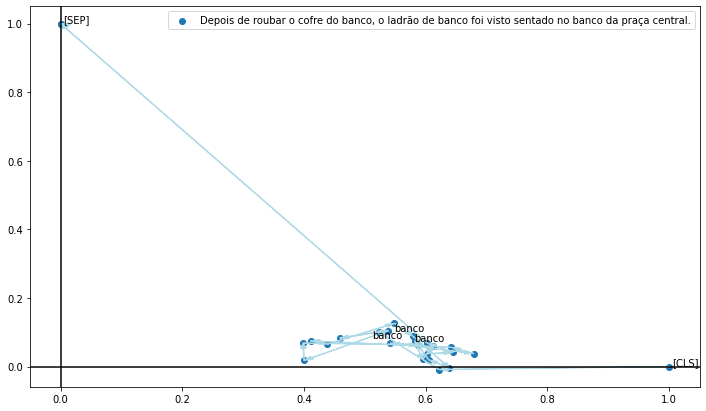

In [31]:
# Aumenta o tamanho da plotagem do gráfico
plt.figure(figsize=(12,7))
plt.axhline(color="black")
plt.axvline(color="black")
plt.scatter(Wp[0,:], Wp[1,:], label=documento)
rX = max(Wp[0,:])-min(Wp[0,:])
rY = max(Wp[1,:])-min(Wp[1,:])
rM = max(rX, rY)
eps = 0.005
for i, token in enumerate(documento_tokenizado):
    if token in ["[CLS]", "[SEP]"]:
        plt.annotate(token, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
    if token == "banco":
        plt.annotate(token, (Wp[0,i]+rX*eps*-6, Wp[1,i]+rX*eps*3))
    if i>0:
        plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color="lightblue", head_length=rM*eps*3, head_width=rM*eps*2, length_includes_head=True)
plt.legend()

# Mostra o gráfico
plt.show()

#### Comparando as sentenças

Dividindo o documento em três sentenças.

['[CLS]', 'Depois', 'de', 'roubar', 'o', 'co', '##fre', 'do', 'banco', '[SEP]']
['[CLS]', 'o', 'lad', '##rão', 'de', 'banco', 'foi', 'visto', '[SEP]']
['[CLS]', 'sentado', 'no', 'banco', 'da', 'praça', 'central', '.', '[SEP]']


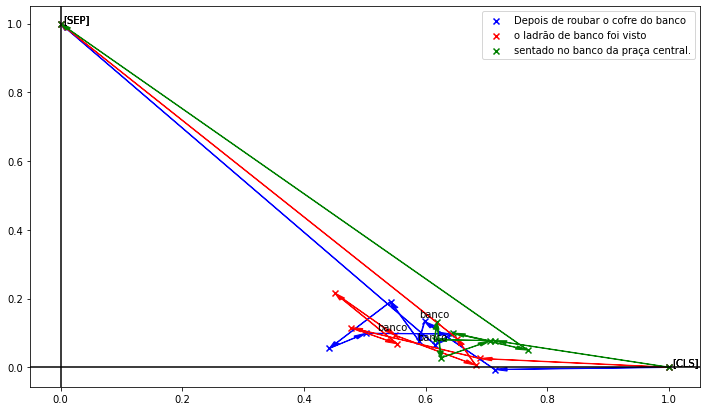

In [32]:
documento = ["Depois de roubar o cofre do banco","o ladrão de banco foi visto","sentado no banco da praça central."]
colors = ["blue", "red", "green"]

# Aumenta o tamanho da plotagem do gráfico
plt.figure(figsize=(12,7))
plt.axhline(color="black")
plt.axvline(color="black")
for n,sentenca in enumerate(documento):
    Wp, tokens = getEmbeddingsVisualUltimaCamada(sentenca, model, tokenizer)
    print(tokens)
    plt.scatter(Wp[0,:], Wp[1,:], color=colors[n], marker="x", label=sentenca)
    rX = max(Wp[0,:])-min(Wp[0,:])
    rY = max(Wp[1,:])-min(Wp[1,:])
    rM = max(rX, rY)
    eps = 0.005
    eps2 = 0.005
    for i, token in enumerate(tokens):
        if token in ["[CLS]", "[SEP]"]:
            plt.annotate(token, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        if token == "banco":
            plt.annotate(token, (Wp[0,i]+rX*eps*-6, Wp[1,i]+rX*eps*3))
        if i>0:
            plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color=colors[n], head_length=rM*eps2*4, head_width=rM*eps2*2, length_includes_head=True)
plt.legend()

# Mostra o gráfico
plt.show()       

### 6.2 - Com a soma das 4 últimas camadas

#### Inicialização

In [33]:
# Define um sentença de exemplo com diversos significados da palavra  "banco"
documento = "Depois de roubar o cofre do banco,"\
        " o ladrão de banco foi visto " \
        "sentado no banco da praça central."

# Adiciona os tokens especiais
documento_marcado = "[CLS] " + documento + " [SEP]"

# Divide a sentença em tokens
documento_tokenizado = tokenizer.tokenize(documento_marcado)

# Mapeia os tokens em seus índices do vocabulário
tokens_indexados = tokenizer.convert_tokens_to_ids(documento_tokenizado)

# Mostra os tokens com seus índices
i = 0
for tup in zip(documento_tokenizado, tokens_indexados):
    print("{:>3} {:<12} {:>6,}".format(i, tup[0], tup[1]))
    i= i + 1

  0 [CLS]           101
  1 Depois        1,603
  2 de              125
  3 roubar       16,150
  4 o               146
  5 co              144
  6 ##fre         1,198
  7 do              171
  8 banco         6,465
  9 ,               117
 10 o               146
 11 lad          13,503
 12 ##rão         1,759
 13 de              125
 14 banco         6,465
 15 foi             262
 16 visto         3,382
 17 sentado      21,541
 18 no              202
 19 banco         6,465
 20 da              180
 21 praça         6,357
 22 central       2,692
 23 .               119
 24 [SEP]           102


O BERT é treinado e espera pares de sentenças, usando 1s e 0s para distinguir entre as duas sentenças. Ou seja, para cada token em "documento_tokenizado", devemos especificar a qual sentença pertence: sentença 0 (uma série de 0s) ou sentença 1 (uma série de 1s). Para nossos propósitos, as entradas de sentença única requerem apenas uma série de 1s; portanto, criaremos um vetor de 1s para cada token em nossa sentença de entrada.

Se você deseja processar duas sentenças, atribua cada palavra na primeira sentença mais o token "[SEP]" a 0 e todos os tokens da segunda sentença a 1.

In [34]:
# Marca cada um dos tokens como pertencentes à sentença "1", pois só iremos analisar uma.
mascara_atencao = [1] * len(documento_tokenizado)

print (mascara_atencao)
print (len(mascara_atencao))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
25


Converte "tokens_indexados" e "semegmentos_ids" em  listas em tensores.

In [35]:
# Importa a bibliteca
import torch

# Converte as entradas de listas para tensores do torch
tokens_tensores = torch.as_tensor([tokens_indexados])
mascara_atencao_tensores = torch.as_tensor([mascara_atencao])

Gera os embeddings para a sentença e retorna a saída em  `outputs`.


In [36]:
# Prediz os atributos dos estados ocultos para cada camada
with torch.no_grad():    
  
    # Retorno de model quando output_hidden_states=True´ é setado:    
    #outputs[0] = last_hidden_state, outputs[1] = pooler_output, outputs[2] = hidden_states
    outputs = model(tokens_tensores, mascara_atencao_tensores)

#### Visualizando o intervalo de valores

Recupera a soma das 4 últimas camadas.

In [37]:
# Recupera a soma das 4 últimas camadas ocultas da saída
sum_4_last_layers = getEmbeddingSoma4UltimasCamadas(outputs)

print ("O vetor da última camada oculta tem o formato:", sum_4_last_layers.size())

O vetor da última camada oculta tem o formato: torch.Size([1, 25, 1024])


Plota de valores para o token.

('banco', 6465)


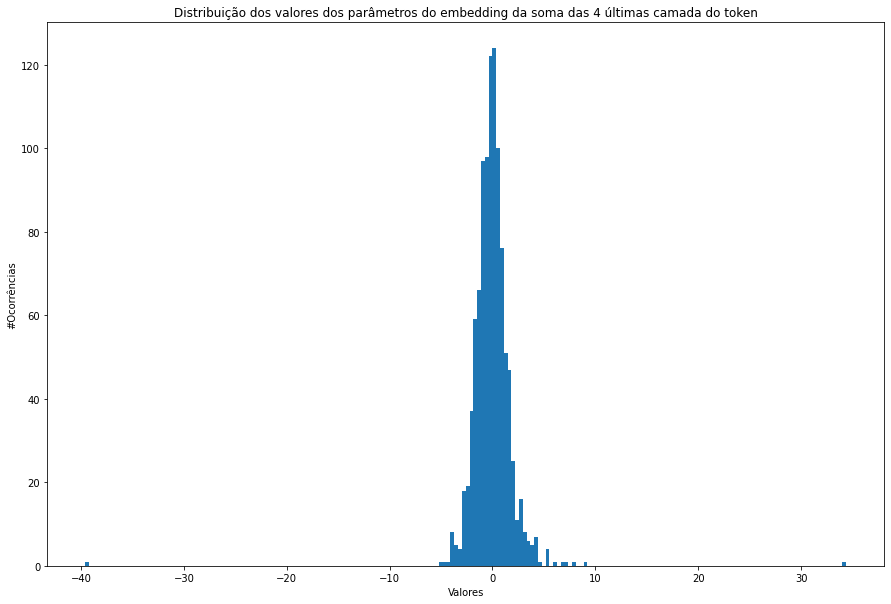

In [38]:
# Import da biblioteca gráfica
import matplotlib.pyplot as plt
%matplotlib inline

# Plota os tokens da sentença
token_i = 8
layer_i = 0

# Recupera o vetor de embeddings da camada para o token
vec = sum_4_last_layers[layer_i][token_i]

# Mostra a palavra do token_i
print((documento_tokenizado[token_i], tokens_indexados[token_i]))

# Aumenta o tamanho da plotagem do gráfico
plt.figure(figsize=(15,10))

# Título do gráfico
plt.title("Distribuição dos valores dos parâmetros do embedding da soma das 4 últimas camada do token")
# Documento do eixo x
plt.xlabel("Valores")
# Documento do eixo y
plt.ylabel("#Ocorrências")

# Cria o histograma com 200 classes
plt.hist(vec, bins=200)

# Mostra o gráfico
plt.show()

Vamos nos livrar da dimensão lotes "batches", pois não precisamos dela.

In [39]:
print ("O vetor da soma das 4 últimas camadas ocultas tem o formato:", sum_4_last_layers.size())

# Remove a dimensão 1, o lote "batches".
# O método ´squeeze´ remove a primeira dimensão(0) pois possui tamanho 1
token_embeddings = torch.squeeze(sum_4_last_layers, dim=0)

print ("O vetor de tokens de embedding da senteça tem o formato:", token_embeddings.size())

O vetor da soma das 4 últimas camadas ocultas tem o formato: torch.Size([1, 25, 1024])
O vetor de tokens de embedding da senteça tem o formato: torch.Size([25, 1024])


Confirmando vetores dependentes do documento


In [40]:
for i, token_str in enumerate(documento_tokenizado):
  print (i, token_str)

0 [CLS]
1 Depois
2 de
3 roubar
4 o
5 co
6 ##fre
7 do
8 banco
9 ,
10 o
11 lad
12 ##rão
13 de
14 banco
15 foi
16 visto
17 sentado
18 no
19 banco
20 da
21 praça
22 central
23 .
24 [SEP]


Exibe os embenddings das palavras

A banco aparece nos índices 8, 14 e 19.


In [41]:
# Índice das palavras a serem comparadas
palavra1 = 8
palavra2 = 14
palavra3 = 19

print("Os primeiros 5 valores de cada instância de \"banco\".")
print("")
print(documento_tokenizado[palavra1], str(token_embeddings[palavra1][:5]))
print(documento_tokenizado[palavra2], str(token_embeddings[palavra2][:5]))
print(documento_tokenizado[palavra3], str(token_embeddings[palavra3][:5]))

Os primeiros 5 valores de cada instância de "banco".

banco tensor([ 0.1175,  0.2260, -1.7680, -1.4736, -4.0491])
banco tensor([ 0.2538,  1.6631, -2.2089, -0.5098, -5.3738])
banco tensor([ 0.3593,  4.1334, -0.1122, -1.5973, -3.6433])


#### Comparando as palavras das sentenças
Podemos ver que os valores diferem, mas vamos calcular a semelhança de cosseno entre os vetores para fazer uma comparação mais precisa.

In [42]:
# Importando as bibliotecas
from scipy.spatial.distance import cosine

print("Período:", documento)
print("Palavra 1 =", palavra1, "=", documento_tokenizado[palavra1], "(instituição financeira)")
print("Palavra 2 =", palavra2, "=", documento_tokenizado[palavra2], "(instituição financeira)")
print("Palavra 3 =", palavra3, "=", documento_tokenizado[palavra3], "(assento)")

# Calcula a similaridade de coseno entre as palavras banco
# Em "ladrão de banco" versus "banco da praça" (diferentes significados).
banco_diferente = 1 - cosine(token_embeddings[palavra2], token_embeddings[palavra3])

print("Vetor de similaridade  para diferentes significados(",palavra2,",",palavra3,"):  %.2f" % banco_diferente)

# Calcula a similaridade de coseno entre as palavras banco
# Em "ladrão de banco" versus "cofre do banco" (mesmo significado).
mesmo_banco = 1 - cosine(token_embeddings[palavra2], token_embeddings[palavra1])

print("Vetor de similaridade  para mesmo significado(",palavra2,",",palavra1,"):  %.2f" % mesmo_banco)

# Calcula a similaridade de coseno entre as palavras banco
# Em "cofre do banco" versus "banco da praça" (diferente significados).
banco_diferente2 = 1 - cosine(token_embeddings[palavra3], token_embeddings[palavra1])

print("Vetor de similaridade  para diferentes significados(",palavra3,",",palavra1,"):  %.2f" % banco_diferente2)

Período: Depois de roubar o cofre do banco, o ladrão de banco foi visto sentado no banco da praça central.
Palavra 1 = 8 = banco (instituição financeira)
Palavra 2 = 14 = banco (instituição financeira)
Palavra 3 = 19 = banco (assento)
Vetor de similaridade  para diferentes significados( 14 , 19 ):  0.78
Vetor de similaridade  para mesmo significado( 14 , 8 ):  0.91
Vetor de similaridade  para diferentes significados( 19 , 8 ):  0.79


#### Visualizando a Sentença

Aqui, queremos mostrar a conexão entre os tokens de uma sentença usando a incorporação do BERT. Plotamos as inserções dos tokens em um subespaço, onde (0,1) e (1,0) são os marcadores de partida [CLS] e [SEP] e marcadores finais e finais da sentença.

In [43]:
# Import das bibliotecas
import numpy as np
import torch

import matplotlib.pyplot as plt
%matplotlib inline

Transforma  o vetor de embendings em um array.

In [44]:
# Transforma tokens embeddings em um array
embeddings = token_embeddings.numpy()

Base selecionada para que o [CLS] e o [SEP] passem para (0,1) e (1,0)

In [45]:
# Converte para um array
W = np.array(embeddings)
# Transforma em um array
B = np.array([embeddings[0], embeddings[-1]])
# Inverte B.T
Bi = np.linalg.pinv(B.T)

Projeta os tokens da palavra no subespaço

In [46]:
Wp = np.matmul(Bi,W.T)

Plota o gráfico da sentença

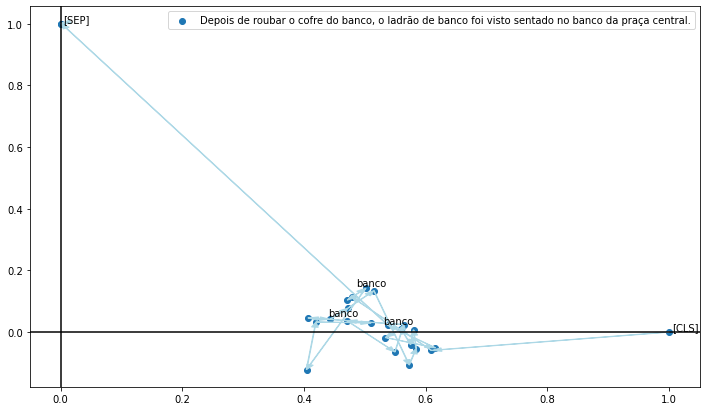

In [47]:
# Aumenta o tamanho da plotagem do gráfico
plt.figure(figsize=(12,7))
plt.axhline(color="black")
plt.axvline(color="black")
plt.scatter(Wp[0,:], Wp[1,:], label=documento)
rX = max(Wp[0,:])-min(Wp[0,:])
rY = max(Wp[1,:])-min(Wp[1,:])
rM = max(rX, rY)
eps = 0.005
for i, token in enumerate(documento_tokenizado):
    if token in ["[CLS]", "[SEP]"]:
        plt.annotate(token, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
    if token == "banco":
        plt.annotate(token, (Wp[0,i]+rX*eps*-6, Wp[1,i]+rX*eps*3))
    if i>0:
        plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color="lightblue", head_length=rM*eps*3, head_width=rM*eps*2, length_includes_head=True)
plt.legend()

# Mostra o gráfico
plt.show()

#### Comparando as sentenças

Dividindo o documento em três sentenças.

['[CLS]', 'Depois', 'de', 'roubar', 'o', 'co', '##fre', 'do', 'banco', '[SEP]']
['[CLS]', 'o', 'lad', '##rão', 'de', 'banco', 'foi', 'visto', '[SEP]']
['[CLS]', 'sentado', 'no', 'banco', 'da', 'praça', 'central', '.', '[SEP]']


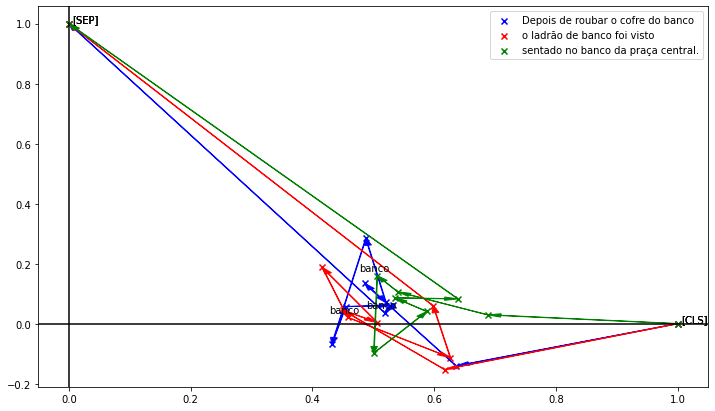

In [48]:
documento = ["Depois de roubar o cofre do banco","o ladrão de banco foi visto","sentado no banco da praça central."]
colors = ["blue", "red", "green"]

# Aumenta o tamanho da plotagem do gráfico
plt.figure(figsize=(12,7))
plt.axhline(color="black")
plt.axvline(color="black")
for n,sentenca in enumerate(documento):
    Wp, tokens = getEmbeddingsVisualSoma4UltimasCamadas(sentenca, model, tokenizer)
    print(tokens)
    plt.scatter(Wp[0,:], Wp[1,:], color=colors[n], marker="x", label=sentenca)
    rX = max(Wp[0,:])-min(Wp[0,:])
    rY = max(Wp[1,:])-min(Wp[1,:])
    rM = max(rX, rY)
    eps = 0.005
    eps2 = 0.005
    for i, token in enumerate(tokens):
        if token in ["[CLS]", "[SEP]"]:
            plt.annotate(token, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        if token == "banco":
            plt.annotate(token, (Wp[0,i]+rX*eps*-6, Wp[1,i]+rX*eps*3))
        if i>0:
            plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color=colors[n], head_length=rM*eps2*4, head_width=rM*eps2*2, length_includes_head=True)
plt.legend()

# Mostra o gráfico
plt.show()       

### 6.3 - Com a concatenação das 4 últimas camadas

#### Inicialização

In [49]:
# Define um sentença de exemplo com diversos significados da palavra  "banco"
documento = "Depois de roubar o cofre do banco,"\
        " o ladrão de banco foi visto " \
        "sentado no banco da praça central."

# Adiciona os tokens especiais
documento_marcado = "[CLS] " + documento + " [SEP]"

# Divide a sentença em tokens
documento_tokenizado = tokenizer.tokenize(documento_marcado)

# Mapeia os tokens em seus índices do vocabulário
tokens_indexados = tokenizer.convert_tokens_to_ids(documento_tokenizado)

# Mostra os tokens com seus índices
i = 0
for tup in zip(documento_tokenizado, tokens_indexados):
    print("{:>3} {:<12} {:>6,}".format(i, tup[0], tup[1]))
    i= i + 1

  0 [CLS]           101
  1 Depois        1,603
  2 de              125
  3 roubar       16,150
  4 o               146
  5 co              144
  6 ##fre         1,198
  7 do              171
  8 banco         6,465
  9 ,               117
 10 o               146
 11 lad          13,503
 12 ##rão         1,759
 13 de              125
 14 banco         6,465
 15 foi             262
 16 visto         3,382
 17 sentado      21,541
 18 no              202
 19 banco         6,465
 20 da              180
 21 praça         6,357
 22 central       2,692
 23 .               119
 24 [SEP]           102


O BERT é treinado e espera pares de sentenças, usando 1s e 0s para distinguir entre as duas sentenças. Ou seja, para cada token em "documento_tokenizado", devemos especificar a qual sentença pertence: sentença 0 (uma série de 0s) ou sentença 1 (uma série de 1s). Para nossos propósitos, as entradas de sentença única requerem apenas uma série de 1s; portanto, criaremos um vetor de 1s para cada token em nossa sentença de entrada.

Se você deseja processar duas sentenças, atribua cada palavra na primeira sentença mais o token "[SEP]" a 0 e todos os tokens da segunda sentença a 1.

In [50]:
# Marca cada um dos tokens como pertencentes à sentença "1", pois só iremos analisar uma.
mascara_atencao = [1] * len(documento_tokenizado)

print (mascara_atencao)
print (len(mascara_atencao))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
25


Converte "tokens_indexados" e "semegmentos_ids" em  listas em tensores.

In [51]:
# Importa a bibliteca
import torch

# Converte as entradas de listas para tensores do torch
tokens_tensores = torch.as_tensor([tokens_indexados])
mascara_atencao_tensores = torch.as_tensor([mascara_atencao])

Gera os embeddings para a sentença e retorna a saída em  `outputs`.


In [52]:
# Prediz os atributos dos estados ocultos para cada camada
with torch.no_grad():    
  
    # Retorno de model quando output_hidden_states=True´ é setado:    
    #outputs[0] = last_hidden_state, outputs[1] = pooler_output, outputs[2] = hidden_states
    outputs = model(tokens_tensores, mascara_atencao_tensores)

#### Visualizando o intervalo de valores

Recupera a soma das 4 últimas camadas.

In [53]:
# Recupera a concatenação das 4 últimas camadas ocultas da saída
concat_4_last_layers = getEmbeddingConcat4UltimasCamadas(outputs)

print ("O vetor da concatenação das 4 últimas camadas ocultas tem o formato:", concat_4_last_layers.size())

O vetor da concatenação das 4 últimas camadas ocultas tem o formato: torch.Size([1, 25, 4096])


Plota de valores para o token.

('banco', 6465)


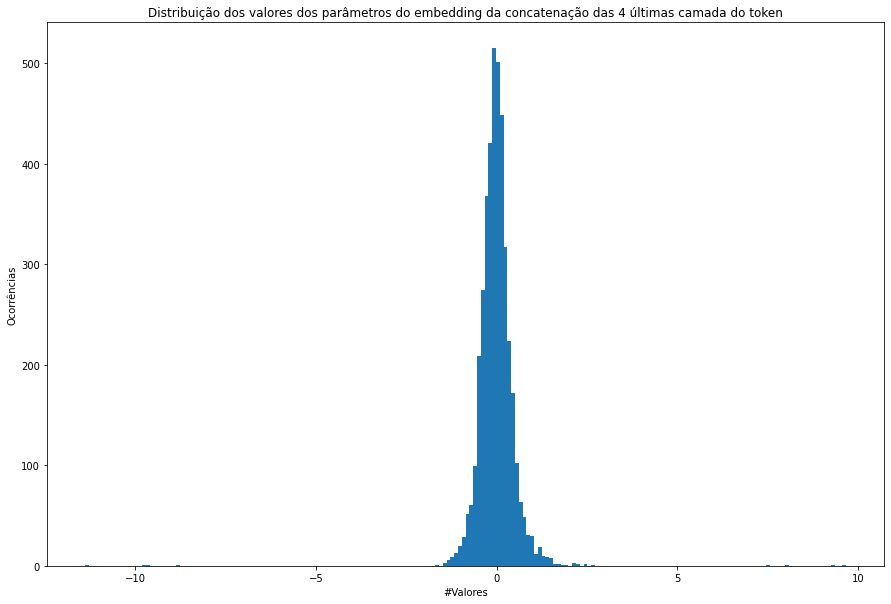

In [54]:
# Import da biblioteca gráfica
import matplotlib.pyplot as plt
%matplotlib inline

# Plota os tokens da sentença
token_i = 8
layer_i = 0

# Recupera o vetor de embeddings da camada para o token
vec = concat_4_last_layers[layer_i][token_i]

# Mostra a palavra do token_i
print((documento_tokenizado[token_i], tokens_indexados[token_i]))

# Aumenta o tamanho da plotagem do gráfico
plt.figure(figsize=(15,10))

# Título do gráfico
plt.title("Distribuição dos valores dos parâmetros do embedding da concatenação das 4 últimas camada do token")
# Documento do eixo x
plt.xlabel("#Valores")
# Documento do eixo y
plt.ylabel("Ocorrências")

# Cria o histograma com 200 classes
plt.hist(vec, bins=200)

# Mostra o gráfico
plt.show()

Vamos nos livrar da dimensão lotes "batches", pois não precisamos dela.

In [55]:
print ("O vetor da concatenação das 4 últimas camadas ocultas tem o formato:", concat_4_last_layers.size())

# Remove a dimensão 1, o lote "batches".
# O método ´squeeze´ remove a primeira dimensão(0) pois possui tamanho 1
token_embeddings = torch.squeeze(concat_4_last_layers, dim=0)

print ("O vetor de tokens de embedding da senteça tem o formato:", token_embeddings.size())

O vetor da concatenação das 4 últimas camadas ocultas tem o formato: torch.Size([1, 25, 4096])
O vetor de tokens de embedding da senteça tem o formato: torch.Size([25, 4096])


Confirmando vetores dependentes do documento


In [56]:
for i, token_str in enumerate(documento_tokenizado):
  print (i, token_str)

0 [CLS]
1 Depois
2 de
3 roubar
4 o
5 co
6 ##fre
7 do
8 banco
9 ,
10 o
11 lad
12 ##rão
13 de
14 banco
15 foi
16 visto
17 sentado
18 no
19 banco
20 da
21 praça
22 central
23 .
24 [SEP]


Exibe os embenddings das palavras

A banco aparece nos índices 8, 14 e 19.


In [57]:
# Índice das palavras a serem comparadas
palavra1 = 8
palavra2 = 14
palavra3 = 19

print("Os primeiros 5 valores de cada instância de \"banco\".")
print("")
print(documento_tokenizado[palavra1], str(token_embeddings[palavra1][:5]))
print(documento_tokenizado[palavra2], str(token_embeddings[palavra2][:5]))
print(documento_tokenizado[palavra3], str(token_embeddings[palavra3][:5]))

Os primeiros 5 valores de cada instância de "banco".

banco tensor([ 0.4261, -0.1251, -0.4406,  0.0736, -1.4059])
banco tensor([ 0.4835,  0.1447, -0.4306,  0.3436, -1.4682])
banco tensor([ 0.3631,  0.9212,  0.1919, -0.2493, -0.9418])


#### Comparando as palavras das sentenças
Podemos ver que os valores diferem, mas vamos calcular a semelhança de cosseno entre os vetores para fazer uma comparação mais precisa.

In [58]:
# Importando as bibliotecas
from scipy.spatial.distance import cosine

print("Período:", documento)
print("Palavra 1 =", palavra1, "=", documento_tokenizado[palavra1], "(instituição financeira)")
print("Palavra 2 =", palavra2, "=", documento_tokenizado[palavra2], "(instituição financeira)")
print("Palavra 3 =", palavra3, "=", documento_tokenizado[palavra3], "(assento)")

# Calcula a similaridade de coseno entre as palavras banco
# Em "ladrão de banco" versus "banco da praça" (diferentes significados).
banco_diferente = 1 - cosine(token_embeddings[palavra2], token_embeddings[palavra3])

print("Vetor de similaridade  para diferentes significados(",palavra2,",",palavra3,"):  %.2f" % banco_diferente)

# Calcula a similaridade de coseno entre as palavras banco
# Em "ladrão de banco" versus "cofre do banco" (mesmo significado).
mesmo_banco = 1 - cosine(token_embeddings[palavra2], token_embeddings[palavra1])

print("Vetor de similaridade  para mesmo significado(",palavra2,",",palavra1,"):  %.2f" % mesmo_banco)

# Calcula a similaridade de coseno entre as palavras banco
# Em "cofre do banco" versus "banco da praça" (diferente significados).
banco_diferente2 = 1 - cosine(token_embeddings[palavra3], token_embeddings[palavra1])

print("Vetor de similaridade  para diferentes significados(",palavra3,",",palavra1,"):  %.2f" % banco_diferente2)

Período: Depois de roubar o cofre do banco, o ladrão de banco foi visto sentado no banco da praça central.
Palavra 1 = 8 = banco (instituição financeira)
Palavra 2 = 14 = banco (instituição financeira)
Palavra 3 = 19 = banco (assento)
Vetor de similaridade  para diferentes significados( 14 , 19 ):  0.77
Vetor de similaridade  para mesmo significado( 14 , 8 ):  0.90
Vetor de similaridade  para diferentes significados( 19 , 8 ):  0.77


#### Visualizando a Sentença

Aqui, queremos mostrar a conexão entre os tokens de uma sentença usando a incorporação do BERT. Plotamos as inserções dos tokens em um subespaço, onde (0,1) e (1,0) são os marcadores de partida [CLS] e [SEP] e marcadores finais e finais da sentença.

In [59]:
# Import das bibliotecas
import numpy as np
import torch

import matplotlib.pyplot as plt
%matplotlib inline

Transforma  o vetor de embendings em um array.

In [60]:
# Transforma tokens embeddings em um array
embeddings = token_embeddings.numpy()

Base selecionada para que o [CLS] e o [SEP] passem para (0,1) e (1,0)

In [61]:
# Converte para um array
W = np.array(embeddings)
# Transforma em um array
B = np.array([embeddings[0], embeddings[-1]])
# Inverte B.T
Bi = np.linalg.pinv(B.T)

Projeta os tokens da palavra no subespaço

In [62]:
Wp = np.matmul(Bi,W.T)

Plota o gráfico da sentença

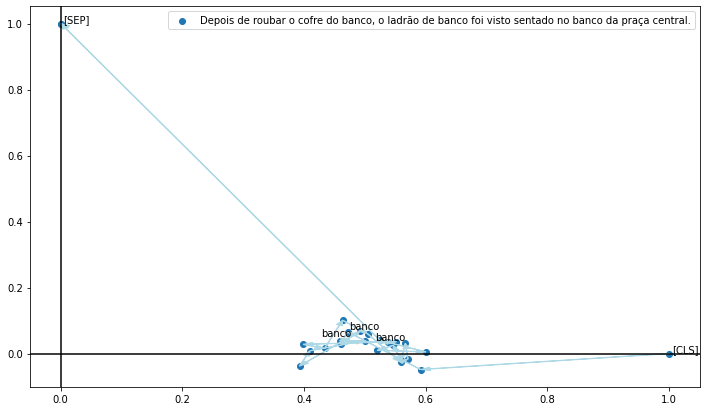

In [63]:
# Aumenta o tamanho da plotagem do gráfico
plt.figure(figsize=(12,7))
plt.axhline(color="black")
plt.axvline(color="black")
plt.scatter(Wp[0,:], Wp[1,:], label=documento)
rX = max(Wp[0,:])-min(Wp[0,:])
rY = max(Wp[1,:])-min(Wp[1,:])
rM = max(rX, rY)
eps = 0.005
for i, token in enumerate(documento_tokenizado):
    if token in ["[CLS]", "[SEP]"]:
        plt.annotate(token, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
    if token == "banco":
        plt.annotate(token, (Wp[0,i]+rX*eps*-6, Wp[1,i]+rX*eps*3))
    if i>0:
        plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color="lightblue", head_length=rM*eps*3, head_width=rM*eps*2, length_includes_head=True)
plt.legend()

# Mostra o gráfico
plt.show()

#### Comparando as sentenças

Dividindo o documento em três sentenças.

['[CLS]', 'Depois', 'de', 'roubar', 'o', 'co', '##fre', 'do', 'banco', '[SEP]']
['[CLS]', 'o', 'lad', '##rão', 'de', 'banco', 'foi', 'visto', '[SEP]']
['[CLS]', 'sentado', 'no', 'banco', 'da', 'praça', 'central', '.', '[SEP]']


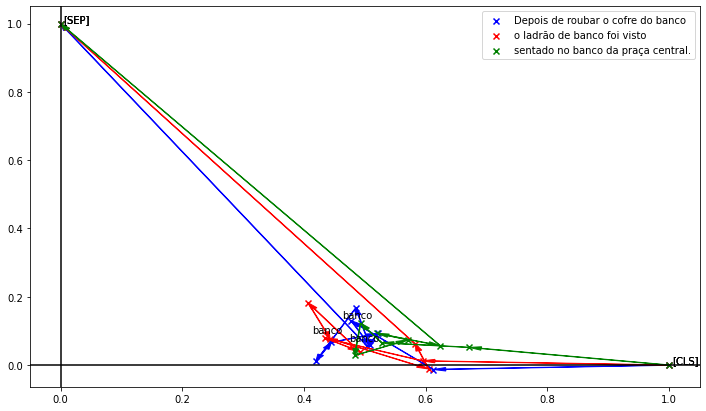

In [64]:
documento = ["Depois de roubar o cofre do banco","o ladrão de banco foi visto","sentado no banco da praça central."]
colors = ["blue", "red", "green"]

# Aumenta o tamanho da plotagem do gráfico
plt.figure(figsize=(12,7))
plt.axhline(color="black")
plt.axvline(color="black")
for n,sentenca in enumerate(documento):
    Wp, tokens = getEmbeddingsVisualConcat4UltimasCamadas(sentenca, model, tokenizer)
    print(tokens)
    plt.scatter(Wp[0,:], Wp[1,:], color=colors[n], marker="x", label=sentenca)
    rX = max(Wp[0,:])-min(Wp[0,:])
    rY = max(Wp[1,:])-min(Wp[1,:])
    rM = max(rX, rY)
    eps = 0.005
    eps2 = 0.005
    for i, token in enumerate(tokens):
        if token in ["[CLS]", "[SEP]"]:
            plt.annotate(token, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        if token == "banco":
            plt.annotate(token, (Wp[0,i]+rX*eps*-6, Wp[1,i]+rX*eps*3))
        if i>0:
            plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color=colors[n], head_length=rM*eps2*4, head_width=rM*eps2*2, length_includes_head=True)
plt.legend()

# Mostra o gráfico
plt.show()       

### 6.4 - Com a soma de todas camadas

#### Inicialização

In [65]:
# Define um sentença de exemplo com diversos significados da palavra  "banco"
documento = "Depois de roubar o cofre do banco,"\
        " o ladrão de banco foi visto " \
        "sentado no banco da praça central."

# Adiciona os tokens especiais
documento_marcado = "[CLS] " + documento + " [SEP]"

# Divide a sentença em tokens
documento_tokenizado = tokenizer.tokenize(documento_marcado)

# Mapeia os tokens em seus índices do vocabulário
tokens_indexados = tokenizer.convert_tokens_to_ids(documento_tokenizado)

# Mostra os tokens com seus índices
i = 0
for tup in zip(documento_tokenizado, tokens_indexados):
    print("{:>3} {:<12} {:>6,}".format(i, tup[0], tup[1]))
    i= i + 1

  0 [CLS]           101
  1 Depois        1,603
  2 de              125
  3 roubar       16,150
  4 o               146
  5 co              144
  6 ##fre         1,198
  7 do              171
  8 banco         6,465
  9 ,               117
 10 o               146
 11 lad          13,503
 12 ##rão         1,759
 13 de              125
 14 banco         6,465
 15 foi             262
 16 visto         3,382
 17 sentado      21,541
 18 no              202
 19 banco         6,465
 20 da              180
 21 praça         6,357
 22 central       2,692
 23 .               119
 24 [SEP]           102


O BERT é treinado e espera pares de sentenças, usando 1s e 0s para distinguir entre as duas sentenças. Ou seja, para cada token em "documento_tokenizado", devemos especificar a qual sentença pertence: sentença 0 (uma série de 0s) ou sentença 1 (uma série de 1s). Para nossos propósitos, as entradas de sentença única requerem apenas uma série de 1s; portanto, criaremos um vetor de 1s para cada token em nossa sentença de entrada.

Se você deseja processar duas sentenças, atribua cada palavra na primeira sentença mais o token "[SEP]" a 0 e todos os tokens da segunda sentença a 1.

In [66]:
# Marca cada um dos tokens como pertencentes à sentença "1", pois só iremos analisar uma.
mascara_atencao = [1] * len(documento_tokenizado)

print (mascara_atencao)
print (len(mascara_atencao))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
25


Converte "tokens_indexados" e "semegmentos_ids" em  listas em tensores.

In [67]:
# Importa a bibliteca
import torch

# Converte as entradas de listas para tensores do torch
tokens_tensores = torch.as_tensor([tokens_indexados])
mascara_atencao_tensores = torch.as_tensor([mascara_atencao])

Gera os embeddings para a sentença e retorna a saída em  `outputs`.


In [68]:
# Prediz os atributos dos estados ocultos para cada camada
with torch.no_grad():    
  
    # Retorno de model quando output_hidden_states=True´ é setado:    
    #outputs[0] = last_hidden_state, outputs[1] = pooler_output, outputs[2] = hidden_states
    outputs = model(tokens_tensores, mascara_atencao_tensores)

#### Visualizando o intervalo de valores

Recupera a soma de todas as camadas.

In [69]:
# Recupera a soma de todas as camadas camada oculta
sum_all_layers = getEmbeddingSomaTodasAsCamada(outputs)

print ("O vetor da soma de todas as camadas ocultas tem o formato:", sum_all_layers.size())

O vetor da soma de todas as camadas ocultas tem o formato: torch.Size([1, 25, 1024])


Plota de valores para o token.

('banco', 6465)


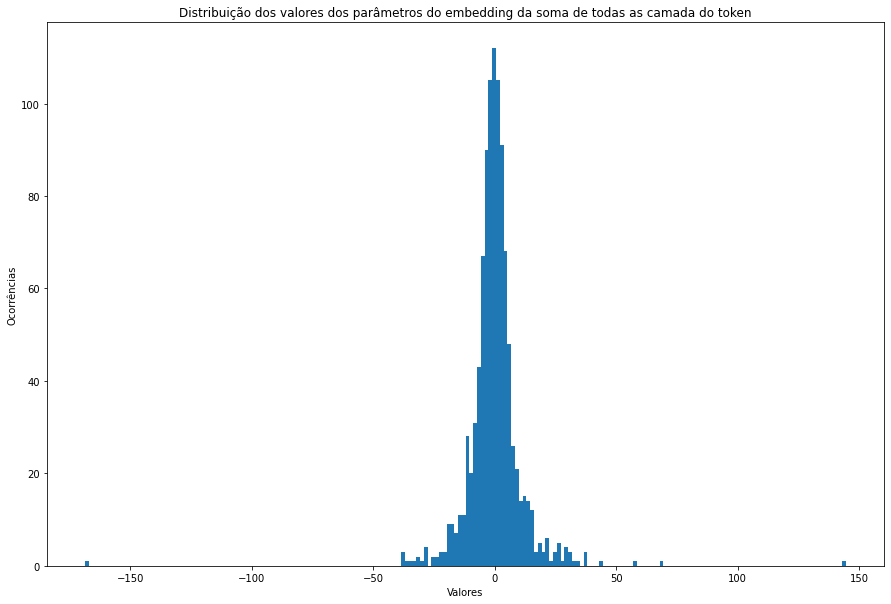

In [70]:
# Import da biblioteca gráfica
import matplotlib.pyplot as plt
%matplotlib inline

# Plota os tokens da sentença
token_i = 8
layer_i = 0

# Recupera o vetor de embeddings da camada para o token
vec = sum_all_layers[layer_i][token_i]

# Mostra a palavra do token_i
print((documento_tokenizado[token_i], tokens_indexados[token_i]))

# Aumenta o tamanho da plotagem do gráfico
plt.figure(figsize=(15,10))

# Título do gráfico
plt.title("Distribuição dos valores dos parâmetros do embedding da soma de todas as camada do token")
# Documento do eixo x
plt.xlabel("Valores")
# Documento do eixo y
plt.ylabel("Ocorrências")

# Cria o histograma com 200 classes
plt.hist(vec, bins=200)

# Mostra o gráfico
plt.show()

Vamos nos livrar da dimensão lotes "batches", pois não precisamos dela.

In [71]:
print ("O vetor da soma de todas as camadas ocultas tem o formato:", sum_all_layers.size())

# Remove a dimensão 1, o lote "batches".
# O método ´squeeze´ remove a primeira dimensão(0) pois possui tamanho 1
token_embeddings = torch.squeeze(sum_all_layers, dim=0)

print ("O vetor de tokens de embedding da senteça tem o formato:", token_embeddings.size())

O vetor da soma de todas as camadas ocultas tem o formato: torch.Size([1, 25, 1024])
O vetor de tokens de embedding da senteça tem o formato: torch.Size([25, 1024])


Confirmando vetores dependentes do documento


In [72]:
for i, token_str in enumerate(documento_tokenizado):
  print (i, token_str)

0 [CLS]
1 Depois
2 de
3 roubar
4 o
5 co
6 ##fre
7 do
8 banco
9 ,
10 o
11 lad
12 ##rão
13 de
14 banco
15 foi
16 visto
17 sentado
18 no
19 banco
20 da
21 praça
22 central
23 .
24 [SEP]


Exibe os embenddings das palavras

A banco aparece nos índices 8, 14 e 19.


In [73]:
# Índice das palavras a serem comparadas
palavra1 = 8
palavra2 = 14
palavra3 = 19

print("Os primeiros 5 valores de cada instância de \"banco\".")
print("")
print(documento_tokenizado[palavra1], str(token_embeddings[palavra1][:5]))
print(documento_tokenizado[palavra2], str(token_embeddings[palavra2][:5]))
print(documento_tokenizado[palavra3], str(token_embeddings[palavra3][:5]))

Os primeiros 5 valores de cada instância de "banco".

banco tensor([ -5.2033,  12.1676,  -7.6282,  -5.4350, -31.5356])
banco tensor([  7.4555,   8.7766,  -6.9918,  -2.3114, -38.8645])
banco tensor([ -6.1800,  14.2602,  -0.1844, -12.2310, -26.8182])


#### Comparando as palavras das sentenças
Podemos ver que os valores diferem, mas vamos calcular a semelhança de cosseno entre os vetores para fazer uma comparação mais precisa.

In [74]:
# Importando as bibliotecas
from scipy.spatial.distance import cosine

print("Período:", documento)
print("Palavra 1 =", palavra1, "=", documento_tokenizado[palavra1], "(instituição financeira)")
print("Palavra 2 =", palavra2, "=", documento_tokenizado[palavra2], "(instituição financeira)")
print("Palavra 3 =", palavra3, "=", documento_tokenizado[palavra3], "(assento)")

# Calcula a similaridade de coseno entre as palavras banco
# Em "ladrão de banco" versus "banco da praça" (diferentes significados).
banco_diferente = 1 - cosine(token_embeddings[palavra2], token_embeddings[palavra3])

print("Vetor de similaridade  para diferentes significados(",palavra2,",",palavra3,"):  %.2f" % banco_diferente)

# Calcula a similaridade de coseno entre as palavras banco
# Em "ladrão de banco" versus "cofre do banco" (mesmo significado).
mesmo_banco = 1 - cosine(token_embeddings[palavra2], token_embeddings[palavra1])

print("Vetor de similaridade  para mesmo significado(",palavra2,",",palavra1,"):  %.2f" % mesmo_banco)

# Calcula a similaridade de coseno entre as palavras banco
# Em "cofre do banco" versus "banco da praça" (diferente significados).
banco_diferente2 = 1 - cosine(token_embeddings[palavra3], token_embeddings[palavra1])

print("Vetor de similaridade  para diferentes significados(",palavra3,",",palavra1,"):  %.2f" % banco_diferente2)

Período: Depois de roubar o cofre do banco, o ladrão de banco foi visto sentado no banco da praça central.
Palavra 1 = 8 = banco (instituição financeira)
Palavra 2 = 14 = banco (instituição financeira)
Palavra 3 = 19 = banco (assento)
Vetor de similaridade  para diferentes significados( 14 , 19 ):  0.86
Vetor de similaridade  para mesmo significado( 14 , 8 ):  0.92
Vetor de similaridade  para diferentes significados( 19 , 8 ):  0.86


#### Visualizando a Sentença

Aqui, queremos mostrar a conexão entre os tokens de uma sentença usando a incorporação do BERT. Plotamos as inserções dos tokens em um subespaço, onde (0,1) e (1,0) são os marcadores de partida [CLS] e [SEP] e marcadores finais e finais da sentença.

In [75]:
# Import das bibliotecas
import numpy as np
import torch

import matplotlib.pyplot as plt
%matplotlib inline

Transforma  o vetor de embendings em um array.

In [76]:
# Transforma tokens embeddings em um array
embeddings = token_embeddings.numpy()

Base selecionada para que o [CLS] e o [SEP] passem para (0,1) e (1,0)

In [77]:
# Converte para um array
W = np.array(embeddings)
# Transforma em um array
B = np.array([embeddings[0], embeddings[-1]])
# Inverte B.T
Bi = np.linalg.pinv(B.T)

Projeta os tokens da palavra no subespaço

In [78]:
Wp = np.matmul(Bi,W.T)

Plota o gráfico da sentença

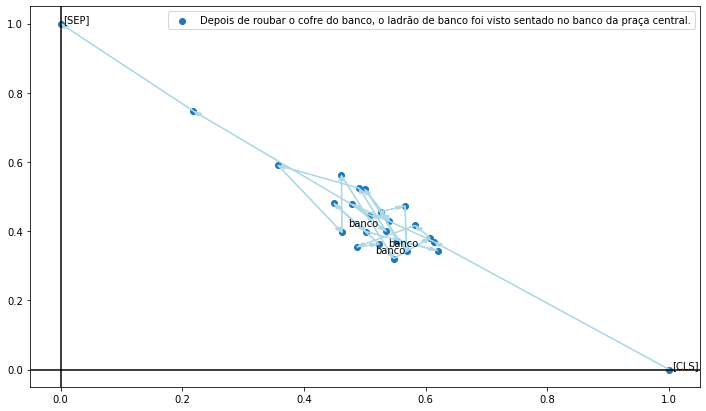

In [79]:
# Aumenta o tamanho da plotagem do gráfico
plt.figure(figsize=(12,7))
plt.axhline(color="black")
plt.axvline(color="black")
plt.scatter(Wp[0,:], Wp[1,:], label=documento)
rX = max(Wp[0,:])-min(Wp[0,:])
rY = max(Wp[1,:])-min(Wp[1,:])
rM = max(rX, rY)
eps = 0.005
for i, token in enumerate(documento_tokenizado):
    if token in ["[CLS]", "[SEP]"]:
        plt.annotate(token, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
    if token == "banco":
        plt.annotate(token, (Wp[0,i]+rX*eps*-6, Wp[1,i]+rX*eps*3))
    if i>0:
        plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color="lightblue", head_length=rM*eps*3, head_width=rM*eps*2, length_includes_head=True)
plt.legend()

# Mostra o gráfico
plt.show()

#### Comparando as sentenças

Dividindo o documento em três sentenças.

['[CLS]', 'Depois', 'de', 'roubar', 'o', 'co', '##fre', 'do', 'banco', '[SEP]']
['[CLS]', 'o', 'lad', '##rão', 'de', 'banco', 'foi', 'visto', '[SEP]']
['[CLS]', 'sentado', 'no', 'banco', 'da', 'praça', 'central', '.', '[SEP]']


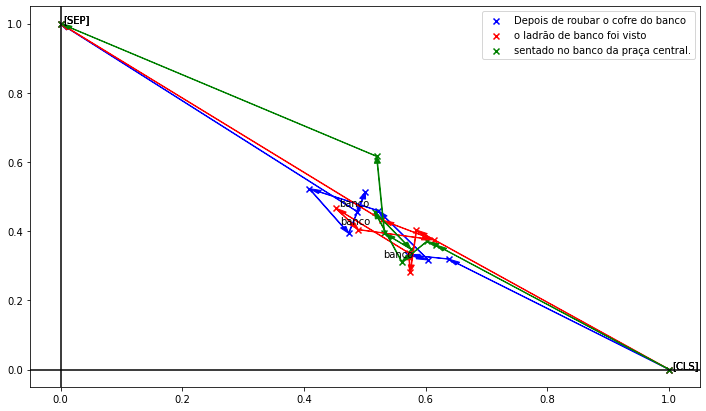

In [80]:
documento = ["Depois de roubar o cofre do banco","o ladrão de banco foi visto","sentado no banco da praça central."]
colors = ["blue", "red", "green"]

# Aumenta o tamanho da plotagem do gráfico
plt.figure(figsize=(12,7))
plt.axhline(color="black")
plt.axvline(color="black")
for n,sentenca in enumerate(documento):
    Wp, tokens = getEmbeddingsVisualSomaTodasAsCamadas(sentenca, model, tokenizer)
    print(tokens)
    plt.scatter(Wp[0,:], Wp[1,:], color=colors[n], marker="x", label=sentenca)
    rX = max(Wp[0,:])-min(Wp[0,:])
    rY = max(Wp[1,:])-min(Wp[1,:])
    rM = max(rX, rY)
    eps = 0.005
    eps2 = 0.005
    for i, token in enumerate(tokens):
        if token in ["[CLS]", "[SEP]"]:
            plt.annotate(token, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        if token == "banco":
            plt.annotate(token, (Wp[0,i]+rX*eps*-6, Wp[1,i]+rX*eps*3))
        if i>0:
            plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color=colors[n], head_length=rM*eps2*4, head_width=rM*eps2*2, length_includes_head=True)
plt.legend()

# Mostra o gráfico
plt.show()       

# 7 - Exemplos

## 7.1 - Exemplo palavra "manga" (2 tokens #)

Outro exemplo

In [81]:
# Define um sentença de exemplo com diversos significados da palavra  "manga"
documento = "João adora manga. Ele pediu sorvete de manga como sobremesa. João sujou a manga da camisa."

# Adiciona os tokens especiais
documento_marcado = "[CLS] " + documento + " [SEP]"

# Divide a sentença em tokens
documento_tokenizado = tokenizer.tokenize(documento_marcado)

# Mapeia os tokens em seus índices do vocabulário
tokens_indexados = tokenizer.convert_tokens_to_ids(documento_tokenizado)

# Mostra os tokens com seus índices
i = 0
for tup in zip(documento_tokenizado, tokens_indexados):
    print("{:>3} {:<12} {:>6,}".format(i, tup[0], tup[1]))
    i= i + 1

  0 [CLS]           101
  1 João          1,453
  2 ado           2,251
  3 ##ra            124
  4 mang          8,037
  5 ##a          22,278
  6 .               119
  7 Ele             787
  8 pediu         5,695
  9 sor          13,449
 10 ##vete       15,957
 11 de              125
 12 mang          8,037
 13 ##a          22,278
 14 como            271
 15 sobre           498
 16 ##mes         1,056
 17 ##a          22,278
 18 .               119
 19 João          1,453
 20 suj           5,980
 21 ##ou            203
 22 a               123
 23 mang          8,037
 24 ##a          22,278
 25 da              180
 26 camisa        7,924
 27 .               119
 28 [SEP]           102


Máscara de atenção das palavras

In [82]:
# Marca cada um dos tokens como pertencentes à sentença "1".
mascara_atencao = [1] * len(documento_tokenizado)

print (mascara_atencao)
print (len(mascara_atencao))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
29


Convertendo as listas em tensores

In [83]:
# Importa a bibliteca
import torch

# Converte as entradas de listas para tensores do torch
tokens_tensores = torch.as_tensor([tokens_indexados])
mascara_atencao_tensores = torch.as_tensor([mascara_atencao])

Gera os embeddings para a sentença. Guarda somente a última camada da rede em `outputs`.


In [84]:
# Prediz os atributos dos estados ocultos para cada camada
with torch.no_grad():
    #output[0] contém last_hidden_states
    outputs = model(tokens_tensores, mascara_atencao_tensores)

Recupera a saída

In [85]:
# Recupera a última e única camada da saída
last_hidden_states = outputs[0]

print ("O vetor da última camada oculta tem o formato:", last_hidden_states.size())

O vetor da última camada oculta tem o formato: torch.Size([1, 29, 1024])


Plota a distribuição dos valores dos embeddings de 2 tokens como um histograma.

('mang', 8037)
('##a', 22278)


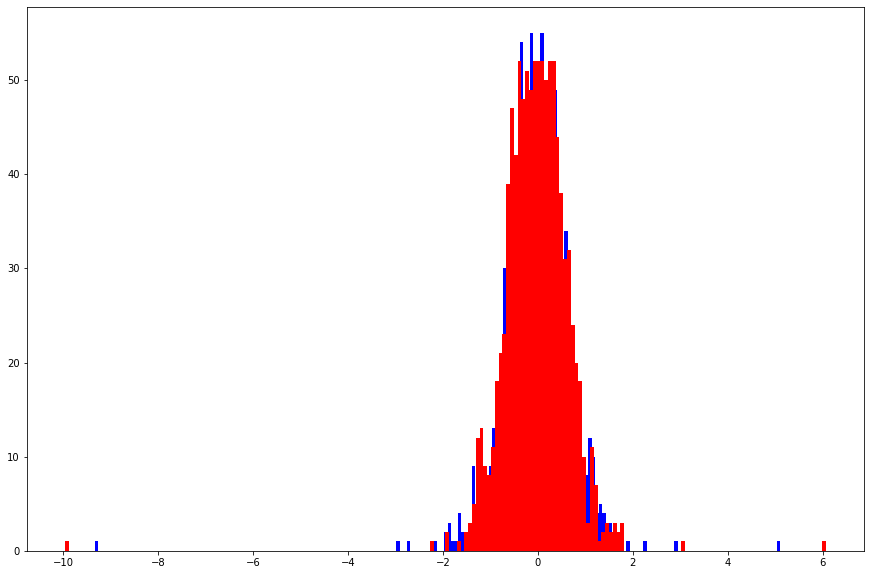

In [86]:
# Import da biblioteca gráfica
import matplotlib.pyplot as plt
%matplotlib inline

# Plota os tokens da sentenca
token_i = 4
layer_i = 0

# Recupera o vetor de embeddings da última camada para o token
vec = last_hidden_states[layer_i][token_i]

# Mostra a palavra do token_i
print((documento_tokenizado[token_i], tokens_indexados[token_i]))

# Plota os valores como um histograma mostrando sua distribuição
plt.figure(figsize=(15,10))
plt.hist(vec, bins=200, color="blue")

# Plota os tokens da sentenca
token_i = 5
layer_i = 0

# Recupera o vetor de embeddings da última camada para o token
vec = last_hidden_states[layer_i][token_i]

# Mostra a palavra do token_i
print((documento_tokenizado[token_i], tokens_indexados[token_i]))

# Cria o histograma com 200 classes
plt.hist(vec, bins=200, color="red")

# Mostra o gráfico
plt.show()

Vamos nos livrar da dimensão lotes "batches", pois não precisamos dela.

In [87]:
# Remove a dimensão 1, o lote "batches".
#O método squeeze remove a primeira dimensão(0) pois possui tamanho 1
token_embeddings = torch.squeeze(last_hidden_states, dim=0)

print ("O vetor de tokens de embedding da senteça tem o formato:", token_embeddings.size())

O vetor de tokens de embedding da senteça tem o formato: torch.Size([29, 1024])


Confirmando vetores dependentes do documento


In [88]:
for i, token_str in enumerate(documento_tokenizado):
  print (i, token_str)

0 [CLS]
1 João
2 ado
3 ##ra
4 mang
5 ##a
6 .
7 Ele
8 pediu
9 sor
10 ##vete
11 de
12 mang
13 ##a
14 como
15 sobre
16 ##mes
17 ##a
18 .
19 João
20 suj
21 ##ou
22 a
23 mang
24 ##a
25 da
26 camisa
27 .
28 [SEP]


Concatenando as subpalavras

In [89]:
#Indíce início e fim do token
tokenInicio = 4
tokenFim = 5

#Inicia com o primeiro token.
token_unificado = documento_tokenizado[tokenInicio]

# Seleciona o restante dos tokens e junta com espaços.
for i in range(tokenInicio + 1, tokenFim + 1):
    
    # Se for um token de subpalavra, combina com o token anterior.
    if documento_tokenizado[i][0:2] == "#":
        token_unificado += documento_tokenizado[i][2:]
    
    # Caso contrário adiciona um espaço ao token.
    else:
        token_unificado += " " + documento_tokenizado[i]

print("token: "" + token_unificado + """)

token:  + token_unificado + 


In [90]:
print(documento_tokenizado[4], str(token_embeddings[4][:5]))

mang tensor([-0.1487,  0.2152,  0.2168,  0.7523, -0.3957])


Exibe os embenddings das palavras

In [91]:
# Índice das palavras a serem comparadas
palavra1 = 4
palavra2 = 12
palavra3 = 23

print("Os primeiros 5 valores de cada instância de \"mang\" e \"#a\"")
print("")
print("Primeira ocorrência:")
print(documento_tokenizado[palavra1], str(token_embeddings[palavra1][:5]), " média=", float(torch.mean(token_embeddings[palavra1][:5])))
print(documento_tokenizado[palavra1+1], str(token_embeddings[palavra1+1][:5]), " média=", float(torch.mean(token_embeddings[palavra1+1][:5])))
print("")
print("Segunda ocorrência:")
print(documento_tokenizado[palavra2], str(token_embeddings[palavra2][:5]), " média=", float(torch.mean(token_embeddings[palavra2+1][:5])))
print(documento_tokenizado[palavra2+1], str(token_embeddings[palavra2+1][:5]), " média=", float(torch.mean(token_embeddings[palavra2+1][:5])))
print("")
print("Terceira ocorrência:")
print(documento_tokenizado[palavra3], str(token_embeddings[palavra3][:5]), " média=", float(torch.mean(token_embeddings[palavra3+1][:5])))
print(documento_tokenizado[palavra3+1], str(token_embeddings[palavra3+1][:5]), " média=", float(torch.mean(token_embeddings[palavra3+1][:5])))

Os primeiros 5 valores de cada instância de "mang" e "#a"

Primeira ocorrência:
mang tensor([-0.1487,  0.2152,  0.2168,  0.7523, -0.3957])  média= 0.127969890832901
##a tensor([ 0.2455, -0.3664,  0.1929,  0.0037,  0.7829])  média= 0.1717250794172287

Segunda ocorrência:
mang tensor([-0.2733,  0.1060,  0.1036,  0.8762, -0.4307])  média= 0.0408577062189579
##a tensor([ 0.2110, -0.8259,  0.2851, -0.0856,  0.6197])  média= 0.0408577062189579

Terceira ocorrência:
mang tensor([0.0391, 0.6579, 0.0480, 0.6874, 0.1648])  média= 0.0954260528087616
##a tensor([-0.0986, -0.0280, -0.3158,  0.0221,  0.8974])  média= 0.0954260528087616


#### Comparando as palavras da sentença 1 token

Podemos ver que os valores diferem, mas vamos calcular a semelhança de cosseno entre os vetores para fazer uma comparação mais precisa.

Utiliza somente um token da palavra ("mang")

In [92]:
# Importando as bibliotecas
from scipy.spatial.distance import cosine

print("Período:", documento)
print("Palavra 1 =", palavra1, "=", documento_tokenizado[palavra1], "(fruta)")
print("Palavra 2 =", palavra2, "=", documento_tokenizado[palavra2], "(fruta)")
print("Palavra 3 =", palavra3, "=", documento_tokenizado[palavra3], "(roupa)")

# Calcula a similaridade de coseno entre as palavras maga
# Em "sorvete de manga" versus "sujou a manga" (diferentes significados).
diferente1 = 1 - cosine(token_embeddings[palavra2][:5], token_embeddings[palavra3][:5])

print("Vetor de similaridade para diferentes significados(",palavra2,",",palavra3,"):  %.2f" % diferente1)

# Calcula a similaridade de coseno entre as palavras manga
# Em "adora manga" versus "sorvete de manga" (mesmo significado).
mesmo = 1 - cosine(token_embeddings[palavra2][:5], token_embeddings[palavra1][:5])

print("Vetor de similaridade para mesmo significado(",palavra2,",",palavra1,")       :  %.2f" % mesmo)

# Calcula a similaridade de coseno entre as palavras manga
# Em "adora manga" versus "manga da camisa" (diferente significados).
diferente2 = 1 - cosine(token_embeddings[palavra1][:5], token_embeddings[palavra3][:5])

print("Vetor de similaridade para diferentes significados(",palavra1,",",palavra3,") :  %.2f" % diferente2)

Período: João adora manga. Ele pediu sorvete de manga como sobremesa. João sujou a manga da camisa.
Palavra 1 = 4 = mang (fruta)
Palavra 2 = 12 = mang (fruta)
Palavra 3 = 23 = mang (roupa)
Vetor de similaridade para diferentes significados( 12 , 23 ):  0.60
Vetor de similaridade para mesmo significado( 12 , 4 )       :  0.98
Vetor de similaridade para diferentes significados( 4 , 23 ) :  0.68


#### Comparando as palavras da sentença 2 tokens

Podemos ver que os valores diferem, mas vamos calcular a semelhança de cosseno entre os vetores para fazer uma comparação mais precisa.

Calcula a média dos embeddings dos tokens que forma a palavra.

Utiliza dois tokens da palavra ("mang") e ("#a")

In [93]:
# Importando as bibliotecas
from scipy.spatial.distance import cosine

print("Período:", documento)
print("Palavra 1 =", palavra1, " e ", palavra1 + 1, "=", documento_tokenizado[palavra1], documento_tokenizado[palavra1+1], "(fruta)")
print("Palavra 2 =", palavra2, " e ", palavra2 + 1, "=", documento_tokenizado[palavra2], documento_tokenizado[palavra2+1], "(fruta)")
print("Palavra 3 =", palavra3, " e ", palavra3 + 1, "=", documento_tokenizado[palavra3], documento_tokenizado[palavra3+1], "(roupa)")

# Calcula a similaridade de coseno entre as palavras maga
# Em "sorvete de manga" versus "sujou a manga" (diferentes significados).
# Calcula a média dos tokens dos embeddings
diferente1 = 1 - cosine(
                        (token_embeddings[palavra2][:5]+token_embeddings[palavra2+1][:5])/2, 
                        (token_embeddings[palavra3][:5]+token_embeddings[palavra3+1][:5])/2
                        )
print("Vetor de similaridade para diferentes significados(",palavra2,"e", palavra2+1,",",palavra3,"e",palavra3+1,"):  %.2f" % diferente1)

# Calcula a similaridade de coseno entre as palavras manga
# Em "adora manga" versus "sorvete de manga" (mesmo significado).
# Calcula a média dos tokens dos embeddings
mesmo = 1 - cosine(
                      (token_embeddings[palavra2][:5]+token_embeddings[palavra2+1][:5])/2, 
                      (token_embeddings[palavra1][:5]+token_embeddings[palavra1+1][:5])/2
                  )
print("Vetor de similaridade para mesmo significado(",palavra2,"e", palavra2+1,",",palavra1,"e",palavra1+1,")        :  %.2f" % mesmo)

# Calcula a similaridade de coseno entre as palavras manga
# Em "adora manga" versus "manga da camisa" (diferente significados).
# Calcula a média dos tokens dos embeddings
diferente2 = 1 - cosine(
                        (token_embeddings[palavra1][:5]+token_embeddings[palavra1+1][:5])/2, 
                        (token_embeddings[palavra3][:5]+token_embeddings[palavra3+1][:5])/2
                        )
print("Vetor de similaridade para diferentes significados(",palavra1,"e", palavra1+1,",",palavra3,"e",palavra3+1,")  :  %.2f" % diferente2)

Período: João adora manga. Ele pediu sorvete de manga como sobremesa. João sujou a manga da camisa.
Palavra 1 = 4  e  5 = mang ##a (fruta)
Palavra 2 = 12  e  13 = mang ##a (fruta)
Palavra 3 = 23  e  24 = mang ##a (roupa)
Vetor de similaridade para diferentes significados( 12 e 13 , 23 e 24 ):  0.12
Vetor de similaridade para mesmo significado( 12 e 13 , 4 e 5 )        :  0.84
Vetor de similaridade para diferentes significados( 4 e 5 , 23 e 24 )  :  0.53


#### Visualizando a Sentença

Aqui, queremos mostrar a conexão entre os tokens de uma sentença usando a incorporação do BERT. Plotamos as inserções dos tokens em um subespaço, onde (0,1) e (1,0) são os marcadores de partida [CLS] e [SEP] e marcadores finais e finais da sentença.

In [94]:
# Import das biblioteca
import numpy as np
import torch

import matplotlib.pyplot as plt
%matplotlib inline

Transforma  o vetor de embendings em um array.

In [95]:
# Transforma tokens embeddings em um array
embeddings = token_embeddings.numpy()

Base selecionada para que o [CLS] e o [SEP] passem para (0,1) e (1,0)

In [96]:
# Converte para um array
W = np.array(embeddings)
# Transforma em um array
B = np.array([embeddings[0], embeddings[-1]])
# Inverte B.T
Bi = np.linalg.pinv(B.T)

Projeta os tokens da palavra no subespaço

In [97]:
Wp = np.matmul(Bi,W.T)

Plota o gráfico da sentença

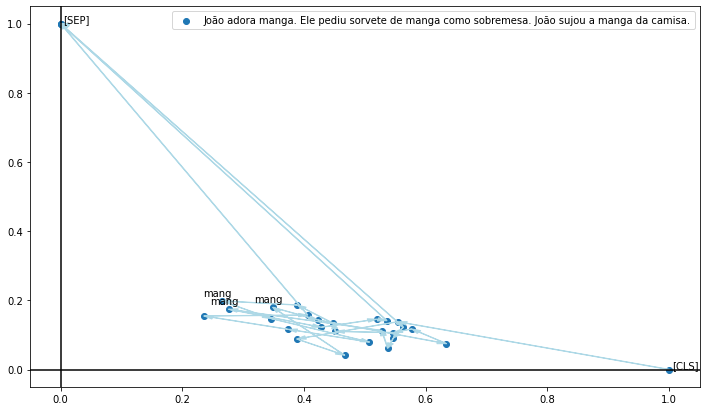

In [98]:
# Aumenta o tamanho da plotagem do gráfico
plt.figure(figsize=(12,7))
plt.axhline(color="black")
plt.axvline(color="black")
plt.scatter(Wp[0,:], Wp[1,:], label=documento)
rX = max(Wp[0,:])-min(Wp[0,:])
rY = max(Wp[1,:])-min(Wp[1,:])
rM = max(rX, rY)
eps = 0.005
for i, token in enumerate(documento_tokenizado):
    if token in ["[CLS]", "[SEP]"]:
        plt.annotate(token, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
    if token in ["mang", "#a"]:
        plt.annotate(token, (Wp[0,i]+rX*eps*-6, Wp[1,i]+rX*eps*3))
    if i>0:
        plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color="lightblue", head_length=rM*eps*3, head_width=rM*eps*2, length_includes_head=True)
plt.legend()

# Mostra o gráfico
plt.show()

#### Comparando as sentenças

Dividindo o documento em três sentenças.

['[CLS]', 'João', 'ado', '##ra', 'mang', '##a', '.', '[SEP]']
['[CLS]', 'Ele', 'pediu', 'sor', '##vete', 'de', 'mang', '##a', 'como', 'sobre', '##mes', '##a', '.', '[SEP]']
['[CLS]', 'João', 'suj', '##ou', 'a', 'mang', '##a', 'da', 'camisa', '.', '[SEP]']


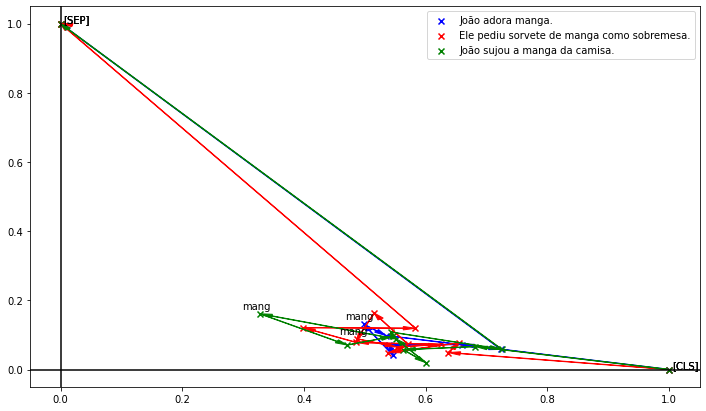

In [99]:
documento = ["João adora manga.", "Ele pediu sorvete de manga como sobremesa.", "João sujou a manga da camisa."]
colors = ["blue", "red", "green"]

# Aumenta o tamanho da plotagem do gráfico
plt.figure(figsize=(12,7))
plt.axhline(color="black")
plt.axvline(color="black")
for n,sentenca in enumerate(documento):
    Wp, tokens = getEmbeddingsVisualUltimaCamada(sentenca, model, tokenizer)
    print(tokens)
    plt.scatter(Wp[0,:], Wp[1,:], color=colors[n], marker="x", label=sentenca)
    rX = max(Wp[0,:])-min(Wp[0,:])
    rY = max(Wp[1,:])-min(Wp[1,:])
    rM = max(rX, rY)
    eps = 0.005
    eps2 = 0.005
    for i, token in enumerate(tokens):
        if token in ["[CLS]", "[SEP]"]:
            plt.annotate(token, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        if token in ["mang", "#a"]:
            plt.annotate(token, (Wp[0,i]+rX*eps*-6, Wp[1,i]+rX*eps*3))
        if i>0:
            plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color=colors[n], head_length=rM*eps2*4, head_width=rM*eps2*2, length_includes_head=True)
plt.legend()

# Mostra o gráfico
plt.show()       

## 7.2 - Exemplo palavra "cabeça"

Outro exemplo

In [100]:
# Define um sentença de exemplo com diversos significados da palavra  "cabeça"
documento = "Não estou com cabeça para isto no momento. Estou com a minha cabeça doendo. Você será o cabeça do projeto."

# Adiciona os tokens especiais
documento_marcado = "[CLS] " + documento + " [SEP]"

# Divide a sentença em tokens
documento_tokenizado = tokenizer.tokenize(documento_marcado)

# Mapeia os tokens em seus índices do vocabulário
tokens_indexados = tokenizer.convert_tokens_to_ids(documento_tokenizado)

# Mostra os tokens com seus índices
i = 0
for tup in zip(documento_tokenizado, tokens_indexados):
    print("{:>3} {:<12} {:>6,}".format(i, tup[0], tup[1]))
    i= i + 1

  0 [CLS]           101
  1 Não           2,542
  2 estou        12,044
  3 com             170
  4 cabeça        3,827
  5 para            221
  6 isto          3,413
  7 no              202
  8 momento       2,182
  9 .               119
 10 Est           9,009
 11 ##ou            203
 12 com             170
 13 a               123
 14 minha         7,122
 15 cabeça        3,827
 16 do              171
 17 ##endo        1,825
 18 .               119
 19 Você         11,976
 20 será          2,810
 21 o               146
 22 cabeça        3,827
 23 do              171
 24 projeto       1,778
 25 .               119
 26 [SEP]           102


Máscara de atenção das palavras

In [101]:
# Marca cada um dos tokens como pertencentes à sentença "1".
mascara_atencao = [1] * len(documento_tokenizado)

print (mascara_atencao)
print (len(mascara_atencao))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
27


Convertendo as listas em tensores

In [102]:
# Import da bibliteca
import torch

# Converte as entradas de listas para tensores do torch
tokens_tensores = torch.as_tensor([tokens_indexados])
mascara_atencao_tensores = torch.as_tensor([mascara_atencao])

Gera os embeddings para a sentença. Guarda somente a última camada da rede em `outputs`.


In [103]:
# Prediz os atributos dos estados ocultos para cada camada
with torch.no_grad():
    #output[0] contém last_hidden_states
    outputs = model(tokens_tensores, mascara_atencao_tensores)

Recupera a saída

In [104]:
# Recupera a última e única camada da saída
last_hidden_states = outputs[0]

print ("O vetor da última camada oculta tem o formato:", last_hidden_states.size())

O vetor da última camada oculta tem o formato: torch.Size([1, 27, 1024])


intervalo de valores para uma determinada camada e token.

('cabeça', 3827)


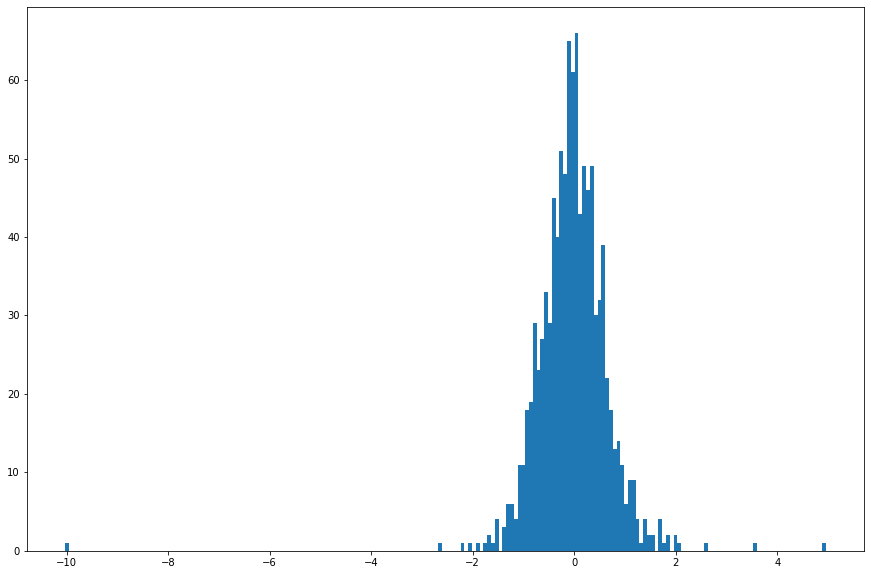

In [105]:
# Import da biblioteca gráfica
import matplotlib.pyplot as plt
%matplotlib inline

# Plota os tokens da sentenca
token_i = 4
layer_i = 0

# Recupera o vetor de embeddings da última camada para o token
vec = last_hidden_states[layer_i][token_i]

# Mostra a palavra do token_i
print((documento_tokenizado[token_i], tokens_indexados[token_i]))

# Aumenta o tamanho da plotagem do gráfico
plt.figure(figsize=(15,10))

# Cria o histograma com 200 classes
plt.hist(vec, bins=200)

# Mostra o gráfico
plt.show()

Vamos nos livrar da dimensão lotes "batches", pois não precisamos dela.

In [106]:
# Remove a dimensão 1, o lote "batches".
#O método squeeze remove a primeira dimensão(0) pois possui tamanho 1
token_embeddings = torch.squeeze(last_hidden_states, dim=0)

print ("O vetor de tokens de embedding da senteça tem o formato:", token_embeddings.size())

O vetor de tokens de embedding da senteça tem o formato: torch.Size([27, 1024])


Confirmando vetores dependentes do documento


In [107]:
for i, token_str in enumerate(documento_tokenizado):
  print (i, token_str)

0 [CLS]
1 Não
2 estou
3 com
4 cabeça
5 para
6 isto
7 no
8 momento
9 .
10 Est
11 ##ou
12 com
13 a
14 minha
15 cabeça
16 do
17 ##endo
18 .
19 Você
20 será
21 o
22 cabeça
23 do
24 projeto
25 .
26 [SEP]


Exibe os embenddings das palavras

In [108]:
# Índice das palavras a serem comparadas
palavra1 = 4
palavra2 = 15
palavra3 = 22

print("Os primeiros 5 valores de cada instância de cabeça.")
print("")
print(documento_tokenizado[palavra1], str(token_embeddings[palavra1][:5]))
print(documento_tokenizado[palavra2], str(token_embeddings[palavra2][:5]))
print(documento_tokenizado[palavra3], str(token_embeddings[palavra3][:5]))

Os primeiros 5 valores de cada instância de cabeça.

cabeça tensor([ 0.4464,  0.3748,  0.2680,  0.0196, -1.2472])
cabeça tensor([ 0.1273, -0.5633,  0.0407, -0.1026, -0.9482])
cabeça tensor([-0.4682, -0.0873,  0.1142, -0.0079,  0.7419])


#### Comparando as palavras da sentença

Podemos ver que os valores diferem, mas vamos calcular a semelhança de cosseno entre os vetores para fazer uma comparação mais precisa.

In [109]:
# Importando as bibliotecas
from scipy.spatial.distance import cosine

print("Período:", documento)
print("Palavra 1 =", palavra1, "=", documento_tokenizado[palavra1], "(corpo)")
print("Palavra 2 =", palavra2, "=", documento_tokenizado[palavra2], "(corpo)")
print("Palavra 3 =", palavra3, "=", documento_tokenizado[palavra3], "(lider)")

# Calcula a similaridade de coseno entre as palavras cabeça
# Em "cabeça doendo" versus "cabeça do projeto" (diferentes significados).
diferente1 = 1 - cosine(token_embeddings[palavra2], token_embeddings[palavra3])

print("Vetor de similaridade para diferentes significados(",palavra2,",",palavra3,"):  %.2f" % diferente1)

# Calcula a similaridade de coseno entre as palavras cabeça
# Em "cabeça doendo" versus "com cabeça" (mesmo significado).
mesmo = 1 - cosine(token_embeddings[palavra2], token_embeddings[palavra1])

print("Vetor de similaridade para mesmo significado(",palavra2,",",palavra1,"):  %.2f" % mesmo)

# Calcula a similaridade de coseno entre as palavras cabeça
# Em "com cabeça" versus "cabeça do projeto" (diferente significados).
diferente2 = 1 - cosine(token_embeddings[palavra1], token_embeddings[palavra3])

print("Vetor de similaridade para diferentes significados(",palavra1,",",palavra3,"):  %.2f" % diferente2)

Período: Não estou com cabeça para isto no momento. Estou com a minha cabeça doendo. Você será o cabeça do projeto.
Palavra 1 = 4 = cabeça (corpo)
Palavra 2 = 15 = cabeça (corpo)
Palavra 3 = 22 = cabeça (lider)
Vetor de similaridade para diferentes significados( 15 , 22 ):  0.72
Vetor de similaridade para mesmo significado( 15 , 4 ):  0.84
Vetor de similaridade para diferentes significados( 4 , 22 ):  0.73


#### Visualizando a Sentença

Aqui, queremos mostrar a conexão entre os tokens de uma sentença usando a incorporação do BERT. Plotamos as inserções dos tokens em um subespaço, onde (0,1) e (1,0) são os marcadores de partida [CLS] e [SEP] e marcadores finais e finais da sentença.

In [110]:
# Importa da bibliotecas
import numpy as np
import torch

import matplotlib.pyplot as plt
%matplotlib inline

Transforma  o vetor de embendings em um array.

In [111]:
# Transforma tokens embeddings em um array
embeddings = token_embeddings.numpy()

Base selecionada para que o [CLS] e o [SEP] passem para (0,1) e (1,0)

In [112]:
# Converte para um array
W = np.array(embeddings)
# Transforma em um array
B = np.array([embeddings[0], embeddings[-1]])
# Inverte B.T
Bi = np.linalg.pinv(B.T)

Projeta os tokens da palavra no subespaço

In [113]:
Wp = np.matmul(Bi,W.T)

Plota o gráfico da sentença

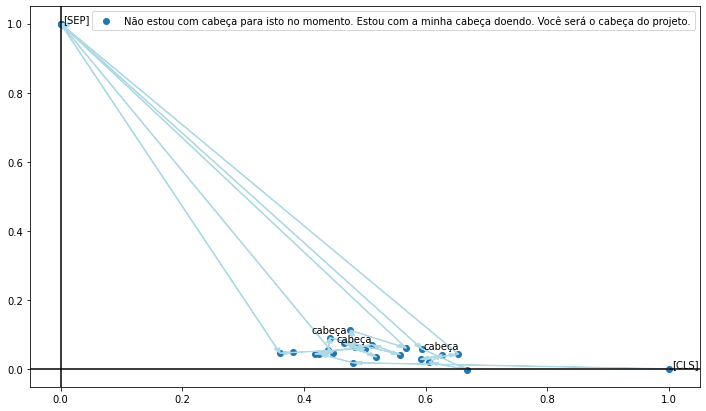

In [114]:
# Aumenta o tamanho da plotagem do gráfico
plt.figure(figsize=(12,7))
plt.axhline(color="black")
plt.axvline(color="black")
plt.scatter(Wp[0,:], Wp[1,:], label=documento)
rX = max(Wp[0,:])-min(Wp[0,:])
rY = max(Wp[1,:])-min(Wp[1,:])
rM = max(rX, rY)
eps = 0.005
for i, token in enumerate(documento_tokenizado):
    if token in ["[CLS]", "[SEP]"]:
        plt.annotate(token, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))  
    if token == "cabeça":
        plt.annotate(token, (Wp[0,i]+rX*eps*-6, Wp[1,i]+rX*eps*3))
    if i>0:
        plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color="lightblue", head_length=rM*eps*3, head_width=rM*eps*2, length_includes_head=True)
plt.legend()

# Mostra o gráfico
plt.show()

#### Comparando as sentenças

Dividindo o documento em três sentenças.

['[CLS]', 'Não', 'estou', 'com', 'cabeça', 'para', 'isto', 'no', 'momento', '.', '[SEP]']
['[CLS]', 'Est', '##ou', 'com', 'a', 'minha', 'cabeça', 'do', '##endo', '.', '[SEP]']
['[CLS]', 'Você', 'será', 'o', 'cabeça', 'do', 'projeto', '.', '[SEP]']


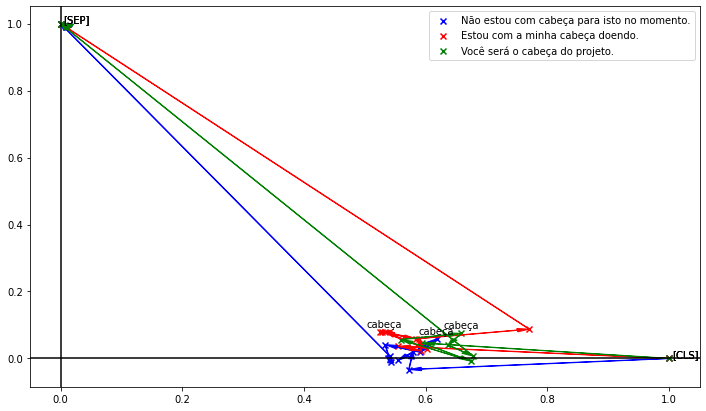

In [115]:
documento = ["Não estou com cabeça para isto no momento.", "Estou com a minha cabeça doendo.", "Você será o cabeça do projeto."]
colors = ["blue", "red", "green"]
# Aumenta o tamanho da plotagem do gráfico
plt.figure(figsize=(12,7))
plt.axhline(color="black")
plt.axvline(color="black")
for n,sentenca in enumerate(documento):
    Wp, tokens = getEmbeddingsVisualUltimaCamada(sentenca, model, tokenizer)
    print(tokens)
    plt.scatter(Wp[0,:], Wp[1,:], color=colors[n], marker="x", label=sentenca)
    rX = max(Wp[0,:])-min(Wp[0,:])
    rY = max(Wp[1,:])-min(Wp[1,:])
    rM = max(rX, rY)
    eps = 0.005
    eps2 = 0.005
    for i, token in enumerate(tokens):
        if token in ["[CLS]", "[SEP]"]:
            plt.annotate(token, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        if token == "cabeça":
            plt.annotate(token, (Wp[0,i]+rX*eps*-6, Wp[1,i]+rX*eps*3))
        if i>0:
            plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color=colors[n], head_length=rM*eps2*4, head_width=rM*eps2*2, length_includes_head=True)
plt.legend()

# Mostra o gráfico
plt.show()       

## 7.3 - Exemplo palavra "pilha"

In [116]:
# Define um sentença de exemplo com diversos significados da palavra  "pilha"
documento = "O que é uma pilha?" \
        "O que é a estrutura de dados pilha?" \
        "Como desempilhar dados de uma pilha?" \
        "Quantos tamanhos existem da pilha de 1.5 volts?"
        
# Adiciona os tokens especiais
documento_marcado = "[CLS] " + documento + " [SEP]"

# Divide a sentença em tokens
documento_tokenizado = tokenizer.tokenize(documento_marcado)

# Mapeia os tokens em seus índices do vocabulário
tokens_indexados = tokenizer.convert_tokens_to_ids(documento_tokenizado)

# Mostra os tokens com seus índices
i = 0
for tup in zip(documento_tokenizado, tokens_indexados):
    print("{:>3} {:<12} {:>6,}".format(i, tup[0], tup[1]))
    i= i + 1

  0 [CLS]           101
  1 O               231
  2 que             179
  3 é               253
  4 uma             230
  5 pilha        18,720
  6 ?               136
  7 O               231
  8 que             179
  9 é               253
 10 a               123
 11 estrutura     2,388
 12 de              125
 13 dados         2,391
 14 pilha        18,720
 15 ?               136
 16 Como          1,602
 17 desem         2,184
 18 ##pi          6,720
 19 ##l          22,290
 20 ##har         2,430
 21 dados         2,391
 22 de              125
 23 uma             230
 24 pilha        18,720
 25 ?               136
 26 Quanto        9,740
 27 ##s          22,281
 28 tamanhos     18,577
 29 existem       3,572
 30 da              180
 31 pilha        18,720
 32 de              125
 33 1               205
 34 .               119
 35 5               732
 36 vol             781
 37 ##ts          1,355
 38 ?               136
 39 [SEP]           102


Máscara de atenção das palavras

In [117]:
# Marca cada um dos tokens como pertencentes à sentença "1".
mascara_atencao = [1] * len(documento_tokenizado)

print (mascara_atencao)
print (len(mascara_atencao))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
40


Convertendo as listas em tensores

In [118]:
# Importa a bibliteca
import torch

# Converte as entradas de listas para tensores do torch
tokens_tensores = torch.as_tensor([tokens_indexados])
mascara_atencao_tensores = torch.as_tensor([mascara_atencao])

Gera os embeddings para a sentença. Guarda somente a última camada da rede em `outputs`.


In [119]:
# Prediz os atributos dos estados ocultos para cada camada
with torch.no_grad():
    # output[0] contém last_hidden_states
    outputs = model(tokens_tensores, mascara_atencao_tensores)

Recupera a saída

In [120]:
# Recupera a última e única camada da saída
last_hidden_states = outputs[0]

print ("O vetor da última camada oculta tem o formato:", last_hidden_states.size())

O vetor da última camada oculta tem o formato: torch.Size([1, 40, 1024])


intervalo de valores para uma determinada camada e token.

('pilha', 18720)


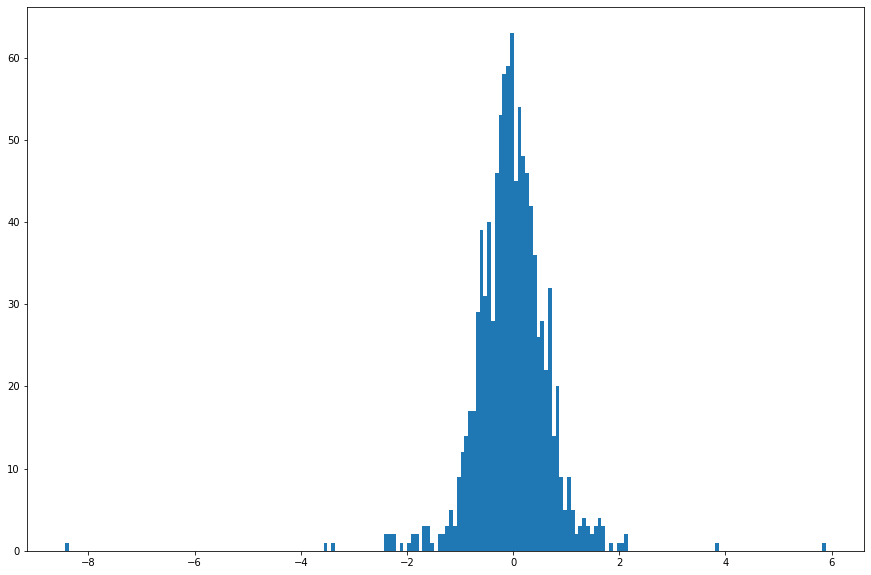

In [121]:
# Import da biblioteca gráfica
import matplotlib.pyplot as plt
%matplotlib inline

# Plota os tokens da sentenca
token_i = 5
layer_i = 0

# Recupera o vetor de embeddings da última camada para o token
vec = last_hidden_states[layer_i][token_i]

# Mostra a palavra do token_i
print((documento_tokenizado[token_i], tokens_indexados[token_i]))

# Aumenta o tamanho da plotagem do gráfico
plt.figure(figsize=(15,10))

# Cria o histograma com 200 classes
plt.hist(vec, bins=200)

# Mostra o gráfico
plt.show()

Vamos nos livrar da dimensão lotes "batches", pois não precisamos dela.

In [122]:
# Remove a dimensão 1, o lote "batches".
#O método squeeze remove a primeira dimensão(0) pois possui tamanho 1
token_embeddings = torch.squeeze(last_hidden_states, dim=0)

print ("O vetor de tokens de embedding da senteça tem o formato:", token_embeddings.size())

O vetor de tokens de embedding da senteça tem o formato: torch.Size([40, 1024])


Confirmando vetores dependentes do documento


In [123]:
for i, token_str in enumerate(documento_tokenizado):
  print (i, token_str)

0 [CLS]
1 O
2 que
3 é
4 uma
5 pilha
6 ?
7 O
8 que
9 é
10 a
11 estrutura
12 de
13 dados
14 pilha
15 ?
16 Como
17 desem
18 ##pi
19 ##l
20 ##har
21 dados
22 de
23 uma
24 pilha
25 ?
26 Quanto
27 ##s
28 tamanhos
29 existem
30 da
31 pilha
32 de
33 1
34 .
35 5
36 vol
37 ##ts
38 ?
39 [SEP]


Exibe os embenddings das palavras

In [124]:
# Índice das palavras a serem comparadas
palavra1 = 5
palavra2 = 14
palavra3 = 24
palavra4 = 31

print("Os primeiros 5 valores de cada instância de  pilha.")
print("")
print(documento_tokenizado[palavra1], str(token_embeddings[palavra1][:5]))
print(documento_tokenizado[palavra2], str(token_embeddings[palavra2][:5]))
print(documento_tokenizado[palavra3], str(token_embeddings[palavra3][:5]))
print(documento_tokenizado[palavra4], str(token_embeddings[palavra4][:5]))

Os primeiros 5 valores de cada instância de  pilha.

pilha tensor([-0.1323, -0.2787,  0.2553,  0.0456, -0.2391])
pilha tensor([ 0.1932,  0.0782,  0.4853,  0.1290, -0.2755])
pilha tensor([-0.3479, -0.4513,  0.1761, -0.1509, -0.4090])
pilha tensor([ 0.0480, -0.3973,  0.3834,  0.0549, -0.1803])


#### Comparando as palavras da sentença

Podemos ver que os valores diferem, mas vamos calcular a semelhança de cosseno entre os vetores para fazer uma comparação mais precisa.

In [125]:
# Importando as bibliotecas
from scipy.spatial.distance import cosine

print("Período:", documento)
print("Palavra 1 =", palavra1, "=", documento_tokenizado[palavra1], "(falta documento)")
print("Palavra 2 =", palavra2, "=", documento_tokenizado[palavra2], "(estrutura de dados)")
print("Palavra 3 =", palavra3, "=", documento_tokenizado[palavra3], "(estrutura de dados)")
print("Palavra 4 =", palavra4, "=", documento_tokenizado[palavra4], "(bateria)")

# Calcula a similaridade de coseno entre as palavras pilha
# Em "pilha 1.5 volts" versus "pilha estrutura" (diferentes significados).
diferente1 = 1- cosine(token_embeddings[palavra2], token_embeddings[palavra3])

print("Vetor de similaridade para mesmo significado(",palavra2,",",palavra3,"):  %.2f" % diferente1)

# Calcula a similaridade de coseno entre as palavras pilha
# Em "pilha 1.5 volts" versus "com pilha" (diferente significado).
diferente2 = 1- cosine(token_embeddings[palavra2], token_embeddings[palavra1])

print("Vetor de similaridade para diferente significado(",palavra2,",",palavra1,"):  %.2f" % diferente2)

# Calcula a similaridade de coseno entre as palavras pilha
# Em "pilha 1.5 volts" versus "pilha estrutura" (diferente significados).
diferente3 = 1- cosine(token_embeddings[palavra1], token_embeddings[palavra3])

print("Vetor de similaridade para diferentes significados(",palavra1,",",palavra3,"):  %.2f" % diferente3)

# Calcula a similaridade de coseno entre as palavras pilha
# Em "pilha" versus "pilha estrutura" (diferente significados).
diferente4 = 1- cosine(token_embeddings[palavra3], token_embeddings[palavra4])

print("Vetor de similaridade para diferentes significados(",palavra3,",",palavra4,"):  %.2f" % diferente4)

# Calcula a similaridade de coseno entre as palavras pilha
# Em "pilha estrutura" versus "dados pilha" (mesmo significados).
diferente5 = 1- cosine(token_embeddings[palavra1], token_embeddings[palavra4])

print("Vetor de similaridade para diferentes significados(",palavra1,",",palavra4,"):  %.2f" % diferente5)


Período: O que é uma pilha?O que é a estrutura de dados pilha?Como desempilhar dados de uma pilha?Quantos tamanhos existem da pilha de 1.5 volts?
Palavra 1 = 5 = pilha (falta documento)
Palavra 2 = 14 = pilha (estrutura de dados)
Palavra 3 = 24 = pilha (estrutura de dados)
Palavra 4 = 31 = pilha (bateria)
Vetor de similaridade para mesmo significado( 14 , 24 ):  0.76
Vetor de similaridade para diferente significado( 14 , 5 ):  0.74
Vetor de similaridade para diferentes significados( 5 , 24 ):  0.96
Vetor de similaridade para diferentes significados( 24 , 31 ):  0.93
Vetor de similaridade para diferentes significados( 5 , 31 ):  0.92


#### Visualizando a Sentença

Aqui, queremos mostrar a conexão entre os tokens de uma sentença usando a incorporação do BERT. Plotamos as inserções dos tokens em um subespaço, onde (0,1) e (1,0) são os marcadores de partida [CLS] e [SEP] e marcadores finais e finais da sentença.

In [126]:
# Import das biblioteca
import numpy as np
import torch

import matplotlib.pyplot as plt
%matplotlib inline

Transforma  o vetor de embendings em um array.

In [127]:
# Transforma tokens embeddings em um array
embeddings = token_embeddings.numpy()

Base selecionada para que o [CLS] e o [SEP] passem para (0,1) e (1,0)

In [128]:
# Converte para um array
W = np.array(embeddings)
# Transforma em um array
B = np.array([embeddings[0], embeddings[-1]])
# Inverte B.T
Bi = np.linalg.pinv(B.T)

Projeta os tokens da palavra no subespaço

In [129]:
Wp = np.matmul(Bi,W.T)

Plota o gráfico da sentença

O que é uma pilha?O que é a estrutura de dados pilha?Como desempilhar dados de uma pilha?Quantos tamanhos existem da pilha de 1.5 volts?


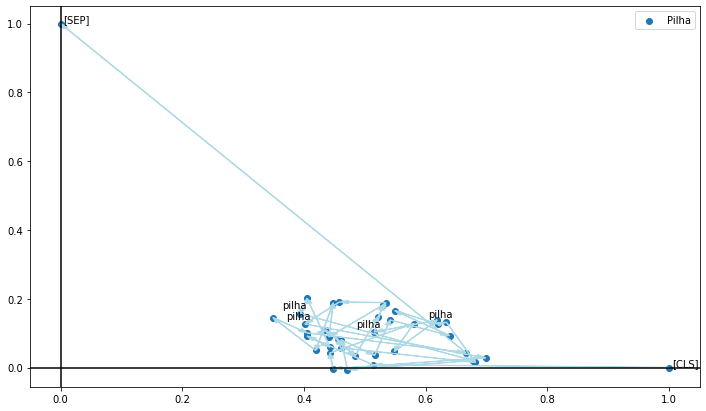

In [130]:
print(documento)
# Aumenta o tamanho da plotagem do gráfico
plt.figure(figsize=(12,7))
plt.axhline(color="black")
plt.axvline(color="black")
plt.scatter(Wp[0,:], Wp[1,:], label="Pilha")
rX = max(Wp[0,:])-min(Wp[0,:])
rY = max(Wp[1,:])-min(Wp[1,:])
rM = max(rX, rY)
eps = 0.005
for i, token in enumerate(documento_tokenizado):
    if token in ["[CLS]", "[SEP]"]:
        plt.annotate(token, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))  
    if token == "pilha":
        plt.annotate(token, (Wp[0,i]+rX*eps*-6, Wp[1,i]+rX*eps*3))
    if i>0:
        plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color="lightblue", head_length=rM*eps*3, head_width=rM*eps*2, length_includes_head=True)
plt.legend()

# Mostra o gráfico
plt.show()

#### Comparando as sentenças

Dividindo o documento em três sentenças.

['[CLS]', 'O', 'que', 'é', 'uma', 'pilha', '?', '[SEP]']
['[CLS]', 'O', 'que', 'é', 'a', 'estrutura', 'de', 'dados', 'pilha', '?', '[SEP]']
['[CLS]', 'Como', 'desem', '##pi', '##l', '##har', 'dados', 'de', 'uma', 'pilha', '?', '[SEP]']
['[CLS]', 'Quanto', '##s', 'tamanhos', 'existem', 'da', 'pilha', 'de', '1', '.', '5', 'vol', '##ts', '?', '[SEP]']


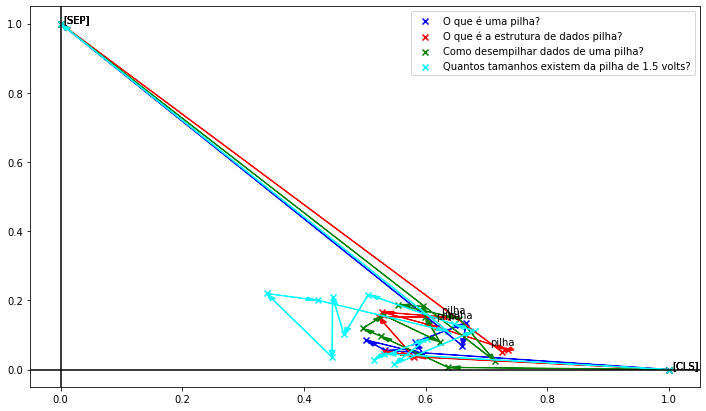

In [131]:
documento = ["O que é uma pilha?",
        "O que é a estrutura de dados pilha?",
        "Como desempilhar dados de uma pilha?",
        "Quantos tamanhos existem da pilha de 1.5 volts?"]

colors = ["blue", "red", "green", "cyan"]

# Aumenta o tamanho da plotagem do gráfico
plt.figure(figsize=(12,7))
plt.axhline(color="black")
plt.axvline(color="black")
for n,sentenca in enumerate(documento):
    Wp, tokens = getEmbeddingsVisualUltimaCamada(sentenca, model, tokenizer)
    print(tokens)
    plt.scatter(Wp[0,:], Wp[1,:], color=colors[n], marker="x", label=sentenca)
    rX = max(Wp[0,:])-min(Wp[0,:])
    rY = max(Wp[1,:])-min(Wp[1,:])
    rM = max(rX, rY)
    eps = 0.005
    eps2 = 0.005
    for i, token in enumerate(tokens):
        if token in ["[CLS]", "[SEP]"]:
            plt.annotate(token, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        if token == "pilha":
            plt.annotate(token, (Wp[0,i]+rX*eps*-6, Wp[1,i]+rX*eps*3))
        if i>0:
            plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color=colors[n], head_length=rM*eps2*4, head_width=rM*eps2*2, length_includes_head=True)
plt.legend()

# Mostra o gráfico
plt.show()       

#### Calculando a similaridade com a primeira sentença

In [132]:
# Import das biblioteca
import pandas as pd

documento = ["O que é uma pilha?",
        "O que é a estrutura de dados pilha?",
        "Como desempilhar dados de uma pilha?",
        "Quantos tamanhos existem da pilha de 1.5 volts?"]

# Converte o documento em um dataframe
df = pd.DataFrame(documento, columns = ["sentenca"])

2022-05-06 23:23:24,675 : INFO : NumExpr defaulting to 2 threads.


In [133]:
# Importa a biblioteca
import torch

# Calcula o embeddings das sentenças
matrix_embedding = []

for i,sentenca in enumerate(documento):
    # Gera os embeddings da sentença utiliza a concatenação das 4 últimas camadas
    embedding, tokens = getEmbeddingsConcat4UltimasCamadas(sentenca, model, tokenizer)    
    # Calcula a média dos embeddings dos tokens da sentença
    media_embedding = torch.mean(embedding, dim=0)    
    # Converte em um array numpy
    media = media_embedding.numpy()
    # Adiciona na lista
    matrix_embedding.append(media)

In [134]:
# Importa a biblioteca
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Coloca todos os embeddings de sentença em uma matriz
embed_matrix = np.array([x for x in matrix_embedding])

# Calcula a similaridade do coseno entre as sentenças
cos_matrix = cosine_similarity(embed_matrix,embed_matrix)

# Coloca a similaridade para a primeira sentença
df["medida"] = cos_matrix[0]

df

,sentenca,medida
0,O que é uma pilha?,1.000000
1,O que é a estrutura de dados pilha?,0.907612
2,Como desempilhar dados de uma pilha?,0.873977
3,Quantos tamanhos existem da pilha de 1.5 volts?,0.890489


#### Mapa de calor calculado com a similaridade cosseno entre todas as sentenças

In [135]:
# Cria o dataframe da lista com as sentenças como nome das colunas
df1 = pd.DataFrame(cos_matrix, columns = documento)
# Indexa pela sentença
df1.index = documento
df1

,O que é uma pilha?,O que é a estrutura de dados pilha?,Como desempilhar dados de uma pilha?,Quantos tamanhos existem da pilha de 1.5 volts?
O que é uma pilha?,1.000000,0.907612,0.873977,0.890489
O que é a estrutura de dados pilha?,0.907612,1.000000,0.896449,0.850535
Como desempilhar dados de uma pilha?,0.873977,0.896449,1.000000,0.886288
Quantos tamanhos existem da pilha de 1.5 volts?,0.890489,0.850535,0.886288,1.000000


In [136]:
# Importando as bibliotecas
import matplotlib

TAMANHO_FONTE = 28
matplotlib.rc("font", size=TAMANHO_FONTE)          # Controla o tamanho do do documento default
matplotlib.rc("axes", titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc("axes", labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc("xtick", labelsize=TAMANHO_FONTE)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc("ytick", labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc("figure", titlesize=TAMANHO_FONTE + 4)   # Tamanho da fonte do título da figura

Text(0.5, 1.0, 'Similaridade do cosseno entre as sentenças\n')

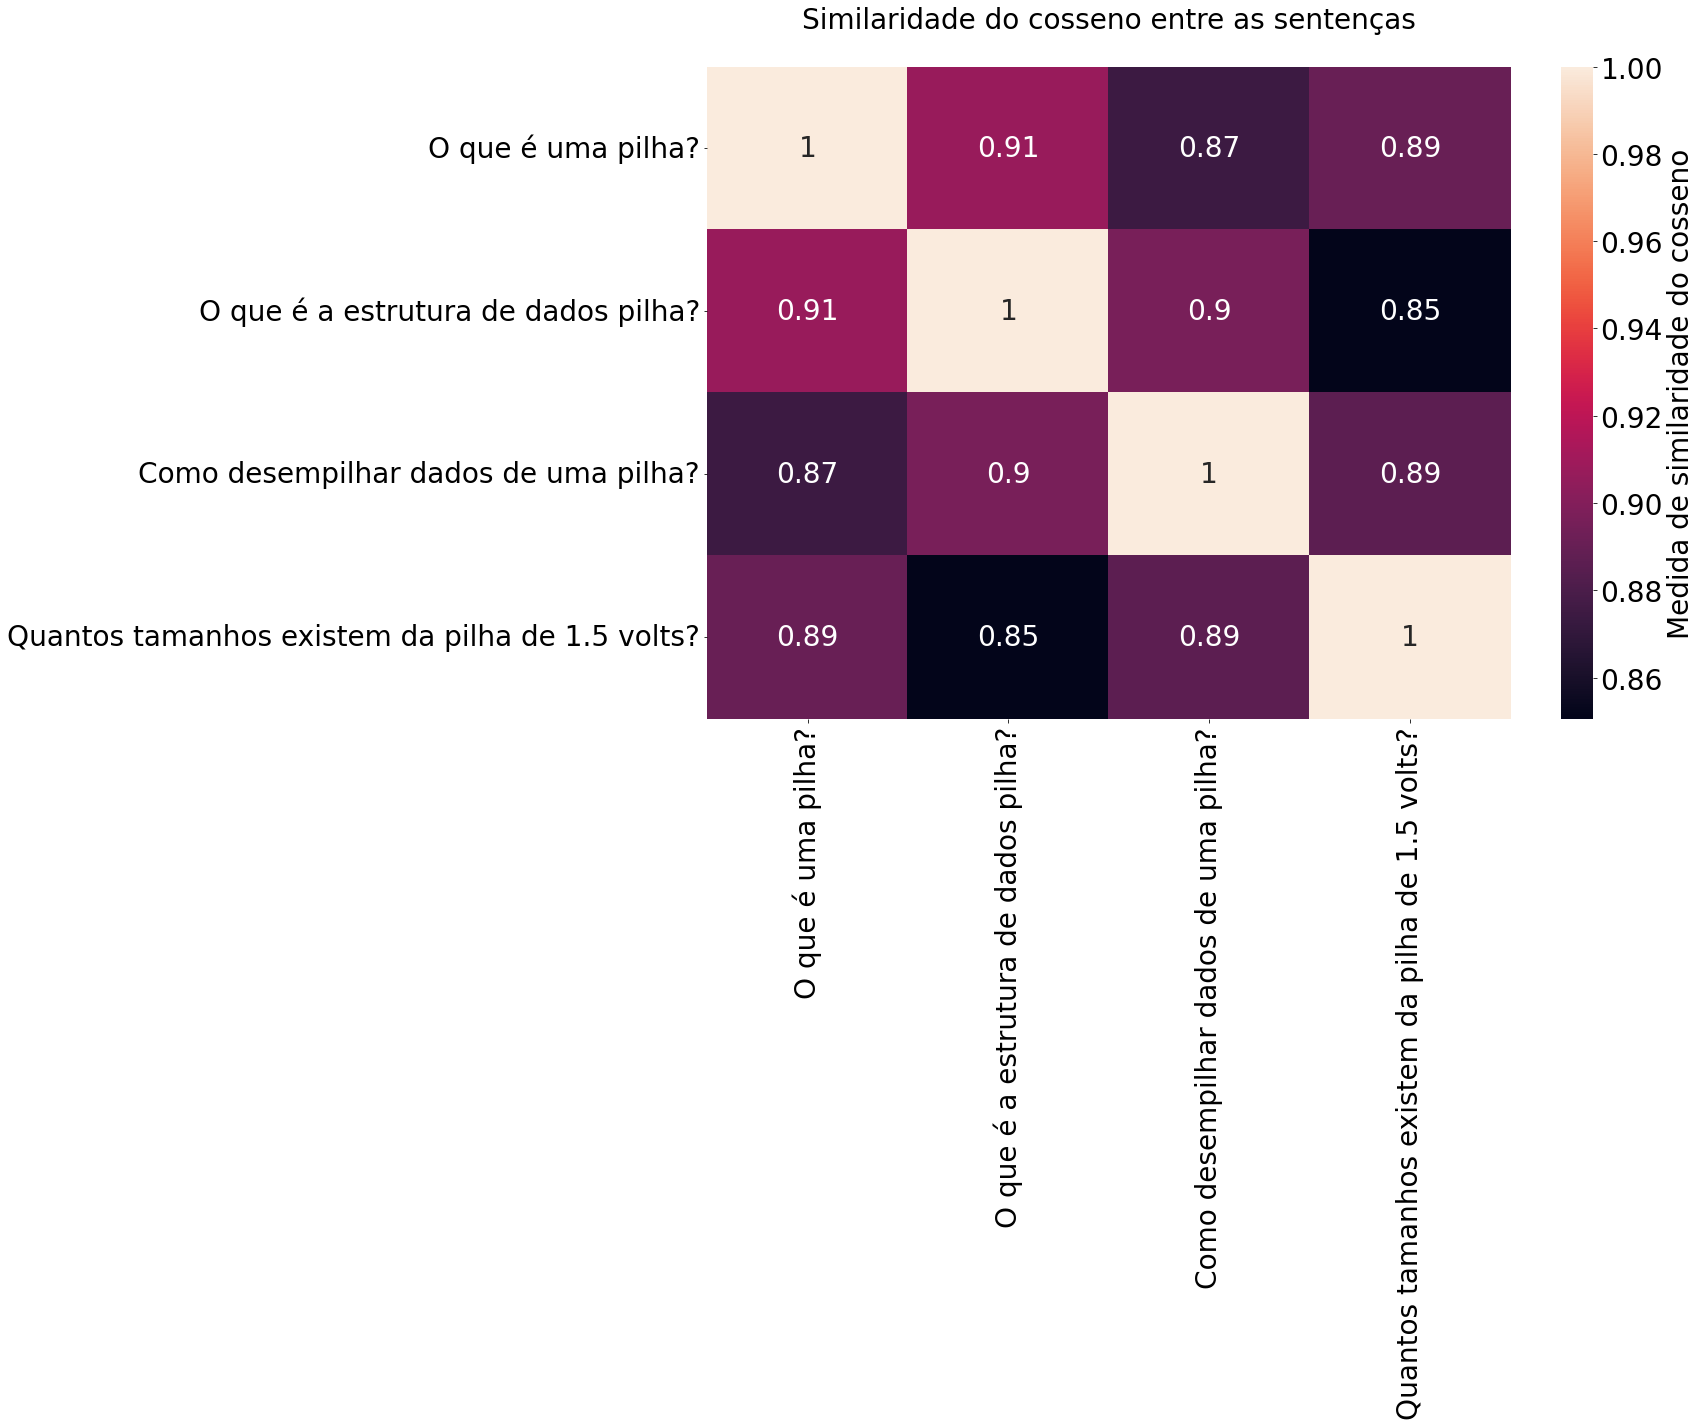

In [137]:
# Importa a biblioteca
import seaborn as sns
import matplotlib.pyplot as plt

# Tamanho da figura
fig, ax = plt.subplots(figsize=(18,12))

# Cria o gráfico
ax = sns.heatmap(cos_matrix, xticklabels=documento, yticklabels=documento, cbar_kws={"label": "Medida de similaridade do cosseno"}, annot=True)

# Coloca o título do gráfico
ax.axes.set_title("Similaridade do cosseno entre as sentenças\n")

## 7.4 Comparando os embeddings das ocorrências da palavra "banco" em uma sentença e orações. 


### 7.4.1 Embeddings da sentença

In [138]:
# Define um sentença de exemplo com diversos significados da palavra  "banco"
documento = "Depois de roubar o cofre do banco, o ladrão de banco foi visto sentado no banco da praça central."

# Adiciona os tokens especiais
documento_marcado = "[CLS] " + documento + " [SEP]"

# Divide a sentença em tokens
documento_tokenizado = tokenizer.tokenize(documento_marcado)

# Mapeia os tokens em seus índices do vocabulário
tokens_indexados = tokenizer.convert_tokens_to_ids(documento_tokenizado)

# Mostra os tokens com seus índices
i = 0
for tup in zip(documento_tokenizado, tokens_indexados):
    print("{:>3} {:<12} {:>6,}".format(i, tup[0], tup[1]))
    i= i + 1

  0 [CLS]           101
  1 Depois        1,603
  2 de              125
  3 roubar       16,150
  4 o               146
  5 co              144
  6 ##fre         1,198
  7 do              171
  8 banco         6,465
  9 ,               117
 10 o               146
 11 lad          13,503
 12 ##rão         1,759
 13 de              125
 14 banco         6,465
 15 foi             262
 16 visto         3,382
 17 sentado      21,541
 18 no              202
 19 banco         6,465
 20 da              180
 21 praça         6,357
 22 central       2,692
 23 .               119
 24 [SEP]           102


Máscara de atenção das palavras

In [139]:
# Marca cada um dos tokens como pertencentes à sentença "1".
mascara_atencao = [1] * len(documento_tokenizado)

print (mascara_atencao)
print (len(mascara_atencao))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
25


Convertendo as listas em tensores

In [140]:
# Importa a bibliteca
import torch

# Converte as entradas de listas para tensores do torch
tokens_tensores = torch.as_tensor([tokens_indexados])
mascara_atencao_tensores = torch.as_tensor([mascara_atencao])

Gera os embeddings para a sentença. Guarda somente a última camada da rede em `outputs`.


In [141]:
# Prediz os atributos dos estados ocultos para cada camada
with torch.no_grad():
    # output[0] contém last_hidden_states
    outputs = model(tokens_tensores, mascara_atencao_tensores)

Recupera a saída

In [142]:
# Recupera a última e única camada da saída
last_hidden_states = outputs[0]

print ("O vetor da última camada oculta tem o formato:", last_hidden_states.size())

O vetor da última camada oculta tem o formato: torch.Size([1, 25, 1024])


Vamos nos livrar da dimensão lotes "batches", pois não precisamos dela.

In [143]:
# Remove a dimensão 1, o lote "batches".
#O método squeeze remove a primeira dimensão(0) pois possui tamanho 1
token_embeddings = torch.squeeze(last_hidden_states, dim=0)

print ("O vetor de tokens de embedding da senteça tem o formato:", token_embeddings.size())

O vetor de tokens de embedding da senteça tem o formato: torch.Size([25, 1024])


Confirmando vetores dependentes do documento


In [144]:
for i, token_str in enumerate(documento_tokenizado):
  print (i, token_str)

0 [CLS]
1 Depois
2 de
3 roubar
4 o
5 co
6 ##fre
7 do
8 banco
9 ,
10 o
11 lad
12 ##rão
13 de
14 banco
15 foi
16 visto
17 sentado
18 no
19 banco
20 da
21 praça
22 central
23 .
24 [SEP]


Exibe os embenddings das palavras

A banco aparece nos índices 8, 14 e 19.


In [145]:
# Índice das palavras a serem comparadas
palavra1 = 8
palavra2 = 14
palavra3 = 19

print("Os primeiros 5 valores de cada instância de \"banco\".")
print("")
print(documento_tokenizado[palavra1], str(token_embeddings[palavra1][:5]))
print(documento_tokenizado[palavra2], str(token_embeddings[palavra2][:5]))
print(documento_tokenizado[palavra3], str(token_embeddings[palavra3][:5]))

Os primeiros 5 valores de cada instância de "banco".

banco tensor([ 0.4261, -0.1251, -0.4406,  0.0736, -1.4059])
banco tensor([ 0.4835,  0.1447, -0.4306,  0.3436, -1.4682])
banco tensor([ 0.3631,  0.9212,  0.1919, -0.2493, -0.9418])


#### Comparando as palavras da sentença

Podemos ver que os valores diferem, mas vamos calcular a semelhança de cosseno entre os vetores para fazer uma comparação mais precisa.

In [146]:
# Importando as bibliotecas
from scipy.spatial.distance import cosine

print("Período:", documento)
print()
print("Palavra 1 =", palavra1, "=", documento_tokenizado[palavra1], "(instituição financeira)")
print("Palavra 2 =", palavra2, "=", documento_tokenizado[palavra2], "(instituição financeira)")
print("Palavra 3 =", palavra3, "=", documento_tokenizado[palavra3], "(assento)")
print()
# Calcula a similaridade de coseno entre as palavras banco
# Em "ladrão de banco" versus "banco da praça" (diferentes significados).
banco_diferente = 1 - cosine(token_embeddings[palavra2], token_embeddings[palavra3])

print("Vetor de similaridade  para diferentes significados(",palavra2,",",palavra3,"):  %.2f" % banco_diferente)

# Calcula a similaridade de coseno entre as palavras banco
# Em "ladrão de banco" versus "cofre do banco" (mesmo significado).
mesmo_banco = 1 - cosine(token_embeddings[palavra2], token_embeddings[palavra1])

print("Vetor de similaridade  para mesmo significado(",palavra2,",",palavra1,"):  %.2f" % mesmo_banco)

# Calcula a similaridade de coseno entre as palavras banco
# Em "cofre do banco" versus "banco da praça" (diferente significados).
banco_diferente2 = 1 - cosine(token_embeddings[palavra3], token_embeddings[palavra1])

print("Vetor de similaridade  para diferentes significados(",palavra3,",",palavra1,"):  %.2f" % banco_diferente2)

Período: Depois de roubar o cofre do banco, o ladrão de banco foi visto sentado no banco da praça central.

Palavra 1 = 8 = banco (instituição financeira)
Palavra 2 = 14 = banco (instituição financeira)
Palavra 3 = 19 = banco (assento)

Vetor de similaridade  para diferentes significados( 14 , 19 ):  0.78
Vetor de similaridade  para mesmo significado( 14 , 8 ):  0.92
Vetor de similaridade  para diferentes significados( 19 , 8 ):  0.77


### 7.4.2 Embeddings das orações

In [147]:
# Define 3 orações de exemplo com diversos significados da palavra  "banco"
documento1 = "Depois de roubar o cofre do banco,"
documento2 = "o ladrão de banco foi visto"
documento3 = "sentado no banco da praça central."

# Adiciona os tokens especiais
documento_marcado1 = "[CLS] " + documento1 + " [SEP]"
documento_marcado2 = "[CLS] " + documento2 + " [SEP]"
documento_marcado3 = "[CLS] " + documento3 + " [SEP]"

# Divide a oração em tokens
documento_tokenizado1 = tokenizer.tokenize(documento_marcado1)
documento_tokenizado2 = tokenizer.tokenize(documento_marcado2)
documento_tokenizado3 = tokenizer.tokenize(documento_marcado3)

# Mapeia os tokens em seus índices do vocabulário
tokens_indexados1 = tokenizer.convert_tokens_to_ids(documento_tokenizado1)
tokens_indexados2 = tokenizer.convert_tokens_to_ids(documento_tokenizado2)
tokens_indexados3 = tokenizer.convert_tokens_to_ids(documento_tokenizado3)

# Mostra os tokens com seus índices
i = 0
print("\nOração 1")
for tup in zip(documento_tokenizado1, tokens_indexados1):
    print("{:>3} {:<12} {:>6,}".format(i, tup[0], tup[1]))
    i= i + 1

i = 0
print("\nOração 2")
for tup in zip(documento_tokenizado2, tokens_indexados3):
    print("{:>3} {:<12} {:>6,}".format(i, tup[0], tup[1]))
    i= i + 1

i = 0
print("\nOração 3")
for tup in zip(documento_tokenizado3, tokens_indexados3):
    print("{:>3} {:<12} {:>6,}".format(i, tup[0], tup[1]))
    i= i + 1        


Oração 1
  0 [CLS]           101
  1 Depois        1,603
  2 de              125
  3 roubar       16,150
  4 o               146
  5 co              144
  6 ##fre         1,198
  7 do              171
  8 banco         6,465
  9 ,               117
 10 [SEP]           102

Oração 2
  0 [CLS]           101
  1 o            21,541
  2 lad             202
  3 ##rão         6,465
  4 de              180
  5 banco         6,357
  6 foi           2,692
  7 visto           119
  8 [SEP]           102

Oração 3
  0 [CLS]           101
  1 sentado      21,541
  2 no              202
  3 banco         6,465
  4 da              180
  5 praça         6,357
  6 central       2,692
  7 .               119
  8 [SEP]           102


Máscara de atenção das palavras

In [148]:
# Marca cada um dos tokens como pertencentes as orações com "1".

print("Oração 1")
mascara_atencao1 = [1] * len(documento_tokenizado1)
print (mascara_atencao1)
print (len(mascara_atencao1))

print("\nOração 2")
mascara_atencao2 = [1] * len(documento_tokenizado2)
print (mascara_atencao2)
print (len(mascara_atencao2))

print("\nOração 3")
mascara_atencao3 = [1] * len(documento_tokenizado3)
print (mascara_atencao3)
print (len(mascara_atencao3))

Oração 1
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
11

Oração 2
[1, 1, 1, 1, 1, 1, 1, 1, 1]
9

Oração 3
[1, 1, 1, 1, 1, 1, 1, 1, 1]
9


Convertendo as listas em tensores

In [149]:
# Importa a bibliteca
import torch

# Converte as entradas de listas para tensores do torch
tokens_tensores1 = torch.as_tensor([tokens_indexados1])
tokens_tensores2 = torch.as_tensor([tokens_indexados2])
tokens_tensores3 = torch.as_tensor([tokens_indexados3])

mascara_atencao_tensores1 = torch.as_tensor([mascara_atencao1])
mascara_atencao_tensores2 = torch.as_tensor([mascara_atencao2])
mascara_atencao_tensores3 = torch.as_tensor([mascara_atencao3])

Gera os embeddings para cada oração. Guarda somente a última camada da rede em `outputs`.


In [150]:
# Prediz os atributos dos estados ocultos para cada camada
with torch.no_grad():
    # output[0] contém last_hidden_states
    outputs1 = model(tokens_tensores1, mascara_atencao_tensores1)

# Prediz os atributos dos estados ocultos para cada camada
with torch.no_grad():
    # output[0] contém last_hidden_states
    outputs2 = model(tokens_tensores2, mascara_atencao_tensores2)

# Prediz os atributos dos estados ocultos para cada camada
with torch.no_grad():
    # output[0] contém last_hidden_states
    outputs3 = model(tokens_tensores3, mascara_atencao_tensores3)    

Recupera a saída

In [151]:
# Recupera a última e única camada da saída
last_hidden_states1 = outputs1[0]
last_hidden_states2 = outputs2[0]
last_hidden_states3 = outputs3[0]

print ("O vetor da última camada oculta da oração 1 tem o formato:", last_hidden_states1.size())
print ("O vetor da última camada oculta da oração 2 tem o formato:", last_hidden_states2.size())
print ("O vetor da última camada oculta da oração 3 tem o formato:", last_hidden_states3.size())

O vetor da última camada oculta da oração 1 tem o formato: torch.Size([1, 11, 1024])
O vetor da última camada oculta da oração 2 tem o formato: torch.Size([1, 9, 1024])
O vetor da última camada oculta da oração 3 tem o formato: torch.Size([1, 9, 1024])


Vamos nos livrar da dimensão lotes "batches", pois não precisamos dela.

In [152]:
# Remove a dimensão 1, o lote "batches".
#O método squeeze remove a primeira dimensão(0) pois possui tamanho 1
token_embeddings1 = torch.squeeze(last_hidden_states1, dim=0)
token_embeddings2 = torch.squeeze(last_hidden_states2, dim=0)
token_embeddings3 = torch.squeeze(last_hidden_states3, dim=0)

print ("O vetor de tokens de embedding da oração 1 tem o formato:", token_embeddings1.size())
print ("O vetor de tokens de embedding da oração 2 tem o formato:", token_embeddings2.size())
print ("O vetor de tokens de embedding da oração 3 tem o formato:", token_embeddings3.size())

O vetor de tokens de embedding da oração 1 tem o formato: torch.Size([11, 1024])
O vetor de tokens de embedding da oração 2 tem o formato: torch.Size([9, 1024])
O vetor de tokens de embedding da oração 3 tem o formato: torch.Size([9, 1024])


Confirmando vetores dependentes do documento


In [153]:
print("\nOração 1")
for i, token_str in enumerate(documento_tokenizado1):
  print (i, token_str)

print("\nOração 2")
for i, token_str in enumerate(documento_tokenizado2):
  print (i, token_str)
  
print("\nOração 3")  
for i, token_str in enumerate(documento_tokenizado3):
  print (i, token_str)  


Oração 1
0 [CLS]
1 Depois
2 de
3 roubar
4 o
5 co
6 ##fre
7 do
8 banco
9 ,
10 [SEP]

Oração 2
0 [CLS]
1 o
2 lad
3 ##rão
4 de
5 banco
6 foi
7 visto
8 [SEP]

Oração 3
0 [CLS]
1 sentado
2 no
3 banco
4 da
5 praça
6 central
7 .
8 [SEP]


Exibe os embenddings das palavras nas orações

A palavra banco aparece nos índices:
- 8 na oração 1 
- 5 na oração 2
- 3 na oração 3


In [154]:
# Índice das palavras a serem comparadas nas orações
palavra1 = 8
palavra2 = 5
palavra3 = 3

print("Os primeiros 5 valores de cada instância de \"banco\" nas orações.")
print("\nOração 1")
print(documento_tokenizado1[palavra1], str(token_embeddings1[palavra1][:5]))
print("\nOração 2")
print(documento_tokenizado2[palavra2], str(token_embeddings2[palavra2][:5]))
print("\nOração 3")
print(documento_tokenizado3[palavra3], str(token_embeddings3[palavra3][:5]))

Os primeiros 5 valores de cada instância de "banco" nas orações.

Oração 1
banco tensor([ 0.4766,  0.0748, -0.5052,  0.2351, -1.5831])

Oração 2
banco tensor([ 0.5374,  0.3064, -0.5108,  0.4402, -1.6011])

Oração 3
banco tensor([ 0.2461,  0.8729, -0.0053,  0.0360, -1.0848])


#### Comparando as palavras das orações

Podemos ver que os valores diferem, mas vamos calcular a semelhança de cosseno entre os vetores para fazer uma comparação mais precisa.

In [155]:
# Importando as bibliotecas
from scipy.spatial.distance import cosine

print("Oração 1:", documento1)
print("Oração 2:", documento2)
print("Oração 3:", documento1)
print()
print("Palavra 1 oração 1 =", palavra1, "=", documento_tokenizado1[palavra1], "(instituição financeira)")
print("Palavra 2 oração 2 =", palavra2, "=", documento_tokenizado2[palavra2], "(instituição financeira)")
print("Palavra 3 oração 3=", palavra3, "=", documento_tokenizado3[palavra3], "(assento)")
print()
# Calcula a similaridade de coseno entre as palavras banco
# Em "ladrão de banco" versus "banco da praça" (diferentes significados).
banco_diferente = 1 - cosine(token_embeddings2[palavra2], token_embeddings3[palavra3])

print("Vetor de similaridade  para diferentes significados(",palavra2,",",palavra3,"):  %.2f" % banco_diferente)

# Calcula a similaridade de coseno entre as palavras banco
# Em "ladrão de banco" versus "cofre do banco" (mesmo significado).
mesmo_banco = 1 - cosine(token_embeddings2[palavra2], token_embeddings1[palavra1])

print("Vetor de similaridade  para mesmo significado(",palavra2,",",palavra1,"):  %.2f" % mesmo_banco)

# Calcula a similaridade de coseno entre as palavras banco
# Em "cofre do banco" versus "banco da praça" (diferente significados).
banco_diferente2 = 1 - cosine(token_embeddings3[palavra3], token_embeddings2[palavra1])

print("Vetor de similaridade  para diferentes significados(",palavra3,",",palavra1,"):  %.2f" % banco_diferente2)

Oração 1: Depois de roubar o cofre do banco,
Oração 2: o ladrão de banco foi visto
Oração 3: Depois de roubar o cofre do banco,

Palavra 1 oração 1 = 8 = banco (instituição financeira)
Palavra 2 oração 2 = 5 = banco (instituição financeira)
Palavra 3 oração 3= 3 = banco (assento)

Vetor de similaridade  para diferentes significados( 5 , 3 ):  0.70
Vetor de similaridade  para mesmo significado( 5 , 8 ):  0.93
Vetor de similaridade  para diferentes significados( 3 , 8 ):  0.15
